In [2]:
pacman::p_load(ggplot2,dplyr,tidyr,data.table,stats,
               vegan,ggpubr,corrplot,Hmisc,GGally,mapproj,
               igraph,network, sna, wesanderson,dils,mapdata,
               RColorBrewer,data.table,dtplyr,cowplot,tibble,
               ggforce,ggnewscale,philentropy,ggdendro,
               ggplot2,dplyr,tidyr,data.table,igraph,ggnet)

## Functions related to the network analysis approach

In [3]:
## the final "full_taxonomy" file is the taxonomy generated by EUKulele and by 
## mmseqs combined together in order to capture accurate labels for groups
## to be used for colors in plotting
full_taxonomy=read.csv(file.path("..","input","eukulele_mmseqs_joined_tax.csv")) %>%
              dplyr::left_join(read.csv(file.path("..","input",
                                                  "eukulele_mmseqs_joined_tax_sarahgroups.csv"))) %>%
    dplyr::mutate(Genome=new_mag_name)

#' Copy the taxonomy and return whether a eukaryote or a prokaryote
#' and its taxonomy string.
# Author: Arianna Krinos ----------------
get_euk_prok <- function(genome_names) {
    modified_df = data.frame(Genome = genome_names) %>% 
        dplyr::left_join(full_taxonomy, by = c("Genome")) %>%
        dplyr::mutate(EukOrProk = as.character(Domain)) %>%
        dplyr::mutate(EukOrProk = case_when(EukOrProk == "Eukaryota" ~ "euk",
                                            EukOrProk == "d__Bacteria" ~ "prok",
                                            TRUE ~ "unclass"))
    return(modified_df)
}


#' Copy the taxonomy and return whether a eukaryote or a prokaryote
#' and its taxonomy string.
# Author: Arianna Krinos ----------------
get_tax_string <- function(genome_names,cluster_groups=cluster_groups) {
    modified_df = data.frame(Genome = as.character(genome_names))%>% 
        dplyr::left_join(cluster_groups %>%
                         dplyr::distinct(Cluster, .keep_all = T),by=c("Genome"="Cluster")) %>%
        dplyr::mutate(Genome = case_when(is.na(Genome)|(grepl("Cluster",Genome)) ~ MAG,
                                          TRUE ~ Genome)) %>%
        dplyr::left_join(full_taxonomy, by = c("Genome")) %>%
        dplyr::mutate(EukOrProk = as.character(Domain_EUKulele)) %>%
        dplyr::mutate(EukOrProk = case_when(EukOrProk == "Eukaryota" ~ "euk",
                                            EukOrProk == "d__Bacteria" ~ "prok",
                                            TRUE ~ "unclass"))
    tax_cols = c("Domain_EUKulele","Supergroup_EUKulele",
                 "Phylum_EUKulele","Class_EUKulele",
                 "Order_EUKulele","Family_EUKulele","Genus_EUKulele","Species_EUKulele")
    modified_df = modified_df %>% unite("tax_combo", all_of(tax_cols), sep=";",remove = TRUE)
    return(modified_df$tax_combo)
}

get_tax_string_no_cluster <- function(genome_names) {
    modified_df = data.frame(Genome = genome_names) %>% 
        dplyr::left_join(full_taxonomy, by = c("Genome")) %>%
        dplyr::mutate(EukOrProk = as.character(Domain_EUKulele)) %>%
        dplyr::mutate(EukOrProk = case_when(EukOrProk == "Eukaryota" ~ "euk",
                                            EukOrProk == "d__Bacteria" ~ "prok",
                                            TRUE ~ "unclass"))
    tax_cols = c("sarah_groups","Domain_EUKulele","Supergroup_EUKulele","Phylum_EUKulele",
                 "Class_EUKulele",
                 "Order_EUKulele","Family_EUKulele","Genus_EUKulele","Species_EUKulele")
    modified_df = modified_df %>% unite("tax_combo", all_of(tax_cols), sep=";",remove = TRUE)
    return(modified_df$tax_combo)
}

#' Combine the cluster names and sort them so that we don't have duplicates based on cluster
#' member ordering.
#' Author: Arianna Krinos -----------------
get_combo <- function(df_graph) { 
    combined_clust = c()
    for (i in c(1:length(df_graph$from))) {
        combined_clust = c(combined_clust,paste(sort(c(df_graph$from[i],df_graph$to[i])),collapse="_"))
    }
    return(combined_clust)
}

Joining, by =
c("Domain_EUKulele",
"Supergroup_EUKulele",
"Phylum_EUKulele",
"Class_EUKulele",
"Order_EUKulele",
"Family_EUKulele",
"Genus_EUKulele",
"Species_EUKulele",
"harriet_groups",
"Kingdom_mmseqs",
"Clade_mmseqs",
"Phylum_mmseqs",
"Class_mmseqs",
"subclass",
"Order_mmseqs",
"Family_mmseqs",
"Genus_mmseqs",
"Species_mmseqs")


## Read in TPM-derived correlations from Python code `network-analysis`

In [4]:
combined_graph_tpm = data.frame(fread(file.path("/vortexfs1/omics/alexander/akrinos/2021-03_Tara/tara-networks/code/combined_graph_tpm_fullpval.csv")))
combined_graph_tpm = combined_graph_tpm[combined_graph_tpm$pval < (1-(1-0.05)**(1/nrow(combined_graph_tpm))),]

## Run if you don't have a copy of `../input/igraph_dataframe_new_tpm.csv`

In [ ]:
for_igraph = combined_graph_tpm[,colnames(combined_graph_tpm) %in% c("mag1","mag2","corrcoef")]

In [ ]:
for_igraph = combined_graph_tpm[,colnames(combined_graph_tpm) %in% c("mag1","mag2","corrcoef")]
for_igraph$Link = ""
translation_dict = read.csv(file.path("..","input","renamed-eukaryotic-mags.tsv"), sep='\t') %>%
    dplyr::bind_rows(read.csv(file.path("..","input","renamed-prokaryotic-mags.tsv"), sep='\t'))
full_taxonomy = full_taxonomy %>% dplyr::left_join(translation_dict,
                                                   by = c("Genome"="old_mag_name")) %>%
    dplyr::filter(!is.na(Genome)) %>% dplyr::rename(old_mag_name=Genome,Genome=new_mag_name)
modified_df = data.frame(Genome = for_igraph$mag1) %>% 
        dplyr::left_join(full_taxonomy %>% dplyr::distinct(Genome,.keep_all=TRUE), by = c("Genome")) %>%
        dplyr::mutate(EukOrProk = as.character(Domain)) %>%
        dplyr::mutate(EukOrProk = case_when(EukOrProk == "Eukaryota" ~ "euk",
                                            EukOrProk == "d__Bacteria" ~ "prok",
                                            TRUE ~ "unclass"))
modified_df2 = data.frame(Genome = for_igraph$mag2) %>% 
        dplyr::left_join(full_taxonomy %>% dplyr::distinct(Genome,.keep_all=TRUE), by = c("Genome")) %>%
        dplyr::mutate(EukOrProk = as.character(Domain)) %>%
        dplyr::mutate(EukOrProk = case_when(EukOrProk == "Eukaryota" ~ "euk",
                                            EukOrProk == "d__Bacteria" ~ "prok",
                                            TRUE ~ "unclass"))

for_igraph = for_igraph %>%
    dplyr::mutate(Dom1=as.character(modified_df$EukOrProk),
                  Dom2=as.character(modified_df2$EukOrProk))

for_igraph = for_igraph %>% dplyr::mutate(Link = case_when((Dom1 == "prok") & (Dom2 == "euk") ~ "Euk-Prok",
                                               (Dom2 == "prok") & (Dom1 == "euk") ~ "Euk-Prok",
                                               (Dom1 == "prok") & (Dom2 == "prok") ~ "Prok-Prok",
                                               (Dom1 == "euk") & (Dom2 == "euk") ~ "Euk-Euk",
                                               TRUE ~ "Other"))
write.csv(for_igraph,file.path("..","input","igraph_dataframe_new_tpm.csv"))

## Run this code every time you restart the notebook

In [5]:
for_igraph = read.csv(file.path("..","input","igraph_dataframe_new_tpm.csv"))

## Filter based on BUSCO completeness

In [6]:
##### FILTER CANDIDATES BASED ON BUSCO COMPLETENESS #####
translation_dict = read.csv(file.path("..","input",'renamed-eukaryotic-mags.tsv'), sep='\t')
busco_completeness = data.frame(fread(file.path("..","input","EUK_BUSCO_CC.csv"))) %>%
    dplyr::left_join(translation_dict,by=c("V1"="old_mag_name"))
for_igraph_buscofilt = for_igraph %>% dplyr::left_join(busco_completeness, by = c("mag1" = "new_mag_name")) %>%
    dplyr::left_join(busco_completeness, by = c("mag2" = "new_mag_name")) %>%
    dplyr::filter((Completeness.x > 30) | (is.na(Completeness.x))) %>%
    dplyr::filter((Completeness.y > 30) | (is.na(Completeness.y))) 

In [7]:
busco_completeness %>% dplyr::filter(grepl("SPO",V1)) %>%
    dplyr::filter(Completeness > 30) %>% dplyr::tally()

n
<int>
143


## Note: we have already filtered by ANI in the revised process for undergoing `coverm`. This is detailed in the `dereplication-and-abundance.ipynb` notebook in this folder.

In [8]:
for_igraph_buscofilt_all = for_igraph_buscofilt %>%
    dplyr::rename(c("from"="mag1","to"="mag2"))

for_igraph_buscofilt = for_igraph_buscofilt %>% dplyr::filter((Link == "Euk-Prok") | (Link == "Euk-Euk")) %>%
    dplyr::rename(c("from"="mag1","to"="mag2"))

In [9]:
reclustered_network = for_igraph_buscofilt %>% 
    dplyr::mutate("Classifications_from" = get_tax_string_no_cluster(for_igraph_buscofilt$from)) %>%
    dplyr::mutate("Classifications_to" = get_tax_string_no_cluster(for_igraph_buscofilt$to)) %>%
    separate(Classifications_to, sep = ";", fill = "left",
                    paste0(c("sarah_groups","Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_to")) %>%
    separate(Classifications_from, sep = ";", fill = "left",
                    paste0(c("sarah_groups","Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_from")) %>%
    dplyr::mutate(Cluster_From=from,Cluster_To=to) %>%
    dplyr::mutate(from = case_when(grepl("Cluster", Cluster_From) ~ Cluster_From,
                                   TRUE ~ from)) %>%
    dplyr::mutate(to = case_when(grepl("Cluster", Cluster_To) ~ Cluster_To,
                                   TRUE ~ to)) %>%
    dplyr::filter(corrcoef > 0.5) %>%
    dplyr::filter(from != to) 
reclustered_network$Domain_to[is.na(reclustered_network$Domain_to)] = "Bacteria"
reclustered_network$Domain_from[is.na(reclustered_network$Domain_from)] = "Bacteria"

reclustered_network_allconnections = for_igraph_buscofilt_all %>% 
    dplyr::mutate("Classifications_from" = get_tax_string_no_cluster(for_igraph_buscofilt_all$from)) %>%
    dplyr::mutate("Classifications_to" = get_tax_string_no_cluster(for_igraph_buscofilt_all$to)) %>%
    separate(Classifications_to, sep = ";", fill = "left",
                    paste0(c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_to")) %>%
    separate(Classifications_from, sep = ";", fill = "left",
                    paste0(c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_from")) %>%
    dplyr::mutate(Cluster_From=from,Cluster_To=to) %>%
    dplyr::mutate(from = case_when(grepl("Cluster", Cluster_From) ~ Cluster_From,
                                   TRUE ~ from)) %>%
    dplyr::mutate(to = case_when(grepl("Cluster", Cluster_To) ~ Cluster_To,
                                   TRUE ~ to)) %>%
    dplyr::filter(from != to) 
reclustered_network_allconnections$Domain_to[is.na(reclustered_network_allconnections$Domain_to)] = "Bacteria"
reclustered_network_allconnections$Domain_from[is.na(reclustered_network_allconnections$Domain_from)] = "Bacteria"


## Now let's generate our actual network figures

IGRAPH 8938bdc UN-- 549 6417 -- 
+ attr: name (v/c), clustermembership (v/n), corrcoef (e/n), Link
| (e/c), Dom1 (e/c), Dom2 (e/c), combined_clust (e/c)
+ edges from 8938bdc (vertex names):
 [1] TOPAZ_SPS4_E052--TOPAZ_SPS4_E010 TOPAZ_SPS3_E064--TOPAZ_NPS4_E003
 [3] TOPAZ_NPS1_E017--TOPAZ_IOS1_E029 TOPAZ_SPS3_E018--TOPAZ_NAS3_E002
 [5] TOPAZ_SPS1_E084--TOPAZ_SPS1_E029 TOPAZ_SAS3_E005--TOPAZ_SAD3_E001
 [7] TOPAZ_SPS3_E081--TOPAZ_SPS3_E035 TOPAZ_SAS3_E014--TOPAZ_NAS3_E009
 [9] TOPAZ_SPS3_E018--TOPAZ_SPS3_E077 TOPAZ_SPS3_E077--TOPAZ_NAS3_E002
[11] TOPAZ_SPS3_E055--TOPAZ_SPS3_E014 TOPAZ_NPS1_E006--TOPAZ_SPS1_E029
[13] TOPAZ_SPS3_E018--TOPAZ_MSS2_E008 TOPAZ_SPS3_E082--TOPAZ_SAD3_E001
+ ... omitted several edges

IGRAPH 8938bdc UN-- 549 6417 -- 
+ attr: name (v/c), classification (v/c), corrcoef (e/n), Link (e/c),
| Dom1 (e/c), Dom2 (e/c), combined_clust (e/c)
+ edges from 8938bdc (vertex names):
 [1] TOPAZ_SPS4_E052--TOPAZ_SPS4_E010 TOPAZ_SPS3_E064--TOPAZ_NPS4_E003
 [3] TOPAZ_NPS1_E017--TOPAZ_IOS1_E029 TOPAZ_SPS3_E018--TOPAZ_NAS3_E002
 [5] TOPAZ_SPS1_E084--TOPAZ_SPS1_E029 TOPAZ_SAS3_E005--TOPAZ_SAD3_E001
 [7] TOPAZ_SPS3_E081--TOPAZ_SPS3_E035 TOPAZ_SAS3_E014--TOPAZ_NAS3_E009
 [9] TOPAZ_SPS3_E018--TOPAZ_SPS3_E077 TOPAZ_SPS3_E077--TOPAZ_NAS3_E002
[11] TOPAZ_SPS3_E055--TOPAZ_SPS3_E014 TOPAZ_NPS1_E006--TOPAZ_SPS1_E029
[13] TOPAZ_SPS3_E018--TOPAZ_MSS2_E008 TOPAZ_SPS3_E082--TOPAZ_SAD3_E001
+ ... omitted several edges

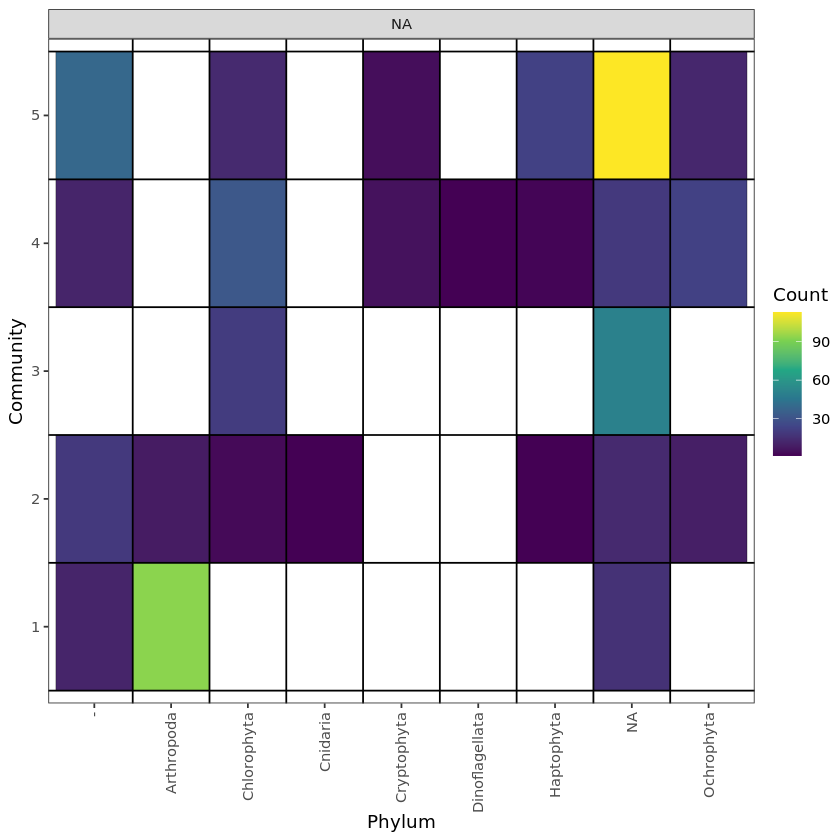

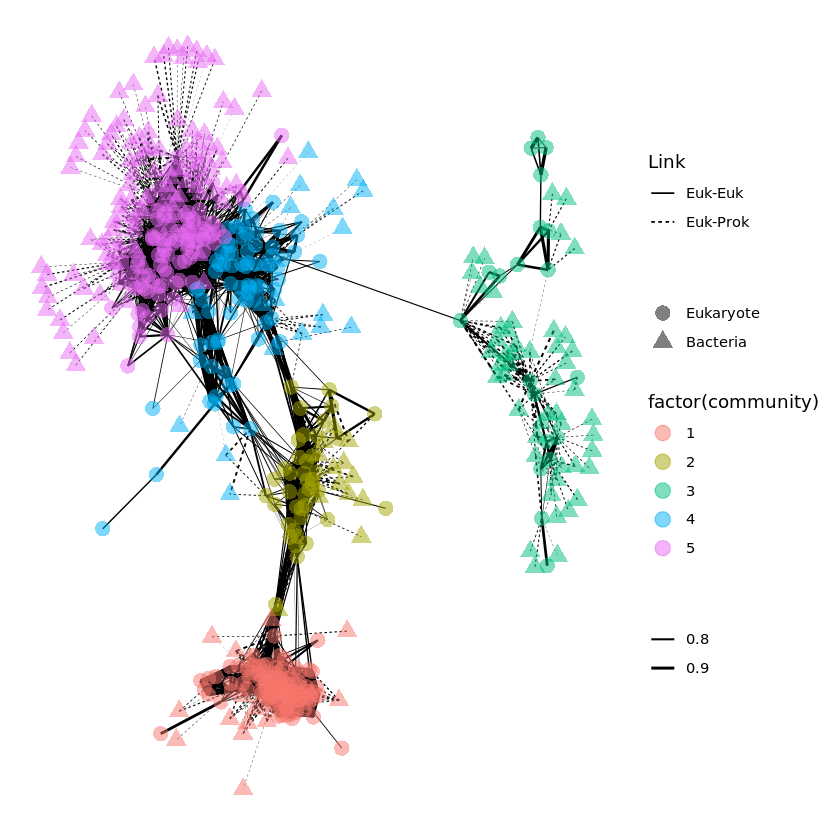

In [8]:
##### GENERATE GRAPH FROM THE REFACTORED NETWORK #####
df_graph <- reclustered_network %>% 
            dplyr::select(to,from,corrcoef,Link,Dom1,Dom2)%>%
            dplyr::filter(corrcoef > 0.7) %>%
            arrange(desc(corrcoef)) %>%
            dplyr::distinct(to,from,Link,Dom1,Dom2,.keep_all=TRUE)
df_graph$combined_clust = get_combo(df_graph)
df_graph <- df_graph %>% dplyr::distinct(combined_clust,.keep_all=TRUE)
refactored_graph <- graph_from_data_frame(df_graph,
                                          directed = FALSE, vertices = NULL)

corr_communities <- cluster_louvain(refactored_graph,weight=df_graph$corrcoef)

set_vertex_attr(refactored_graph, "clustermembership",
                index = V(refactored_graph),
                membership(corr_communities))
set_vertex_attr(refactored_graph, "classification",
                index = V(refactored_graph),
                get_tax_string_no_cluster(V(refactored_graph)$name))

edge_df <- df_graph

# Create a layout of the graph
layout_gr <- as.data.frame(layout.fruchterman.reingold(refactored_graph))
# Add the MAG labels
layout_gr$mag <- V(refactored_graph)$name

# Add the euk-prok labels
edge_df_inform <- edge_df %>% dplyr::select(from,Dom1) %>% dplyr::rename(c("mag"="from","class"="Dom1")) %>%
                    dplyr::bind_rows(edge_df %>% dplyr::select(to,Dom2) %>% 
                                     dplyr::rename(c("mag"="to","class"="Dom2")))
layout_gr$eukprok <- edge_df_inform$class[match(layout_gr$mag,edge_df_inform$mag)]
layout_gr$classification <- get_tax_string_no_cluster(layout_gr$mag)
layout_gr$community <- membership(corr_communities)
# manually re-assign communities so we don't have to re-label them after changing
# ANI cutoff
layout_gr_manual = layout_gr %>% dplyr::mutate(community = case_when(community == 1 ~ 1,
                                                                     community == 2 ~ 3,
                                                                     community == 3 ~ 2,
                                                                     community == 4 ~ 5,
                                                                     community == 5 ~ 4,
                                                                     TRUE ~ as.numeric(community) + 10))

layout_gr<-layout_gr_manual
layout_gr <- layout_gr %>% 
                    dplyr::mutate("degree" = as.numeric(as.character(igraph::degree(refactored_graph,
                                                                                  v = layout_gr$mag))))

large_communities = unique((layout_gr %>% dplyr::distinct(mag,community,.keep_all=TRUE) %>%
    dplyr::group_by(community) %>% dplyr::tally() %>%
    dplyr::filter(n > 3))$community)
layout_gr = layout_gr %>% #dplyr::left_join(cluster_groups,by=c("mag"="Cluster")) %>% 
            #dplyr::mutate(classification = case_when((classification.x == "none") ~ classification.y,
            #                                         TRUE ~ classification.x)) %>%
            dplyr::select(V1,V2,eukprok,mag,classification,community,degree) %>%
   #dplyr::filter(degree > 0) %>%
   dplyr::filter(community %in% large_communities)
   
edge_df = edge_df %>% dplyr::filter((to %in% layout_gr$mag) & (from %in% layout_gr$mag))
layout_gr <- layout_gr %>% dplyr::distinct()

edge_df$from.x <- layout_gr$V1[match(edge_df$from, layout_gr$mag)]  #  match the from locations from the node data.frame we previously connected
edge_df$from.y <- layout_gr$V2[match(edge_df$from, layout_gr$mag)]
edge_df$to.x <- layout_gr$V1[match(edge_df$to, layout_gr$mag)]  #  match the to locations from the node data.frame we previously connected
edge_df$to.y <- layout_gr$V2[match(edge_df$to, layout_gr$mag)]

layout_gr_classes = layout_gr %>% 
    separate(classification, sep = ";", fill = "left",
                    c("Domain","Clade","Kingdom","Supergroup",
                      "Phylum","Class","Order","Family","Genus","Species"))

##### VISUALIZE TAXONOMIC CLASSES IN EACH COMMUNITY #####
taxon_comm = ggplot(layout_gr_classes) + stat_bin2d(aes(x = Phylum, y = factor(community), fill = after_stat(count)),
                                       colour="black") + 
    facet_wrap(~Domain,scales="free_x") + theme_test() + 
    scale_fill_continuous(na.value = "white", type="viridis", name = "Count") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    geom_vline(xintercept=seq(1.5, length(unique(layout_gr_classes$Phylum))-0.5, 1), 
             lwd=0.5, colour="black") + 
    geom_hline(yintercept=seq(0.5, length(unique(layout_gr_classes$community))+0.5, 1), 
             lwd=0.5, colour="black") + 
    ylab("Community") + xlab("Phylum")
taxon_comm
#ggsave(file.path("..","si-figures","network_70cutoff_phylum.png"),
#       dpi=300, width = 6, height = 4, units = "in")

##### PLOT THE NETWORK COMMUNITIES #####
# this is adapted from here https://chrischizinski.github.io/rstats/igraph-ggplotll/
# Plot out the initial layout
n <- length(corr_communities)
palette <- c("#ea8cff","#01a24b","#ec1d92","#998400","#27a3ff",
             "#ff455e","#205297","#ffa56d","#764164","#b5706d","yellow")

network_plot = ggplot() +
    geom_segment(data=edge_df,aes(x=from.x,xend = to.x,y=from.y,
                                  yend = to.y,size=corrcoef,lty=Link),colour="black") +
        geom_point(data=layout_gr,aes(x=V1,y=V2,shape=factor(eukprok),
                                      colour=factor(community)),size=4,alpha=0.5) +
        theme_bw() +
        scale_shape(name = "", solid = TRUE, breaks = c("euk","prok"), labels = c("Eukaryote","Bacteria")) + 
        #scale_color_manual(name = "Community", values = palette) + 
        scale_size(range = c(0, 1),labels=c("0.6","0.7","0.8","0.9"),
                   breaks=c(0.6,0.7,0.8,0.9),name="") + 
        theme(
          axis.text.x = element_blank(),  # remove x-axis text
          axis.text.y = element_blank(), # remove y-axis text
          axis.ticks = element_blank(),  # remove axis ticks
          axis.title.x = element_blank(), # remove x-axis labels
          axis.title.y = element_blank(), # remove y-axis labels
          panel.background = element_blank(), 
          panel.border =element_blank(), 
          panel.grid.major = element_blank(),  #remove major-grid labels
          panel.grid.minor = element_blank(),  #remove minor-grid labels
          plot.background = element_blank())# + xlim(c(-10,30))+ ylim(c(-10,30))
    network_plot

In [13]:
translation_dict = read.csv('/vortexfs1/omics/alexander/halexander/2021-tara-final-paper/rename/renamed-eukaryotic-mags.tsv', sep='\t') %>%
    dplyr::bind_rows(read.csv('/vortexfs1/omics/alexander/halexander/2021-tara-final-paper/rename/renamed-prokaryotic-mags.tsv', sep='\t'))

prokaryotic_taxonomy = data.frame(fread(file.path("/vortexfs1/omics/alexander/akrinos/2021-03_Tara/2021-TOPAZ-MAG-Figures/notebooks/..","data","prokaryote_taxonomy.csv")))%>% 
                        tidyr::separate(classification,sep=";",
                                        c("Domain","Phylum","Class",
                                          "Order","Family","Genus",
                                          "Species")) %>%
    dplyr::filter(Domain=="d__Bacteria") %>%
    dplyr::select(Genome,Phylum,Class,Order,Family) %>%
    dplyr::rename(c("Phylum_Bact"="Phylum","Class_Bact"="Class","Order_Bact"="Order","Family_Bact"="Family")) %>%
    dplyr::left_join(translation_dict,by=c("Genome"="old_mag_name"))

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 650 rows [2, 6, 11, 17, 18, 22, 39, 51, 53, 86, 92, 103, 111, 122, 123, 124, 131, 133, 137, 138, ...].”


In [14]:
layout_gr_classes %>%
    dplyr::left_join(translation_dict,by=c("mag"="new_mag_name")) %>%
    dplyr::left_join(prokaryotic_taxonomy,by=c("mag"="new_mag_name")) %>%
    dplyr::filter(grepl("0-8-5",old_mag_name)) %>%
    dplyr::mutate(Phylum=case_when(Phylum=="NA"~Phylum_Bact,
                                   TRUE ~ Phylum)) %>%
    dplyr::filter(grepl("SPO",old_mag_name))

V1,V2,eukprok,mag,Domain,Clade,Kingdom,Supergroup,Phylum,Class,⋯,Genus,Species,community,degree,old_mag_name,Genome,Phylum_Bact,Class_Bact,Order_Bact,Family_Bact
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
-4.7885214,-2.478380,euk,TOPAZ_SPS1_E084,NA,Choanozoa,Eukaryota,-,-,-,⋯,-,-,2,20,SPO-all-SRF-0-8-5-00_bin-849,NA,NA,NA,NA,NA
3.3838398,8.313722,euk,TOPAZ_SPS1_E038,NA,Haptophyta,Eukaryota,Hacrobia,Haptophyta,Prymnesiophyceae,⋯,-,-,5,62,SPO-SPSG-SRF-0-8-5-00_bin-663,NA,NA,NA,NA,NA
2.8624268,8.049128,euk,TOPAZ_SPS1_E073,NA,Haptophyta,Eukaryota,Hacrobia,Haptophyta,Prymnesiophyceae,⋯,-,-,5,60,SPO-all-SRF-0-8-5-00_bin-664,NA,NA,NA,NA,NA
0.6411727,6.137833,euk,TOPAZ_SPS1_E054,NA,Ochrophyta,Eukaryota,Stramenopiles,Ochrophyta,-,⋯,-,-,4,48,SPO-all-SRF-0-8-5-00_bin-318,NA,NA,NA,NA,NA
2.5276795,7.641962,euk,TOPAZ_SPS1_E086,NA,Haptophyta,Eukaryota,Hacrobia,Haptophyta,Prymnesiophyceae,⋯,-,-,5,67,SPO-all-SRF-0-8-5-00_bin-880,NA,NA,NA,NA,NA
2.7105381,7.845534,euk,TOPAZ_SPS1_E025,NA,Dinoflagellata,Eukaryota,-,-,-,⋯,-,-,5,79,SPO-SPSG-SRF-0-8-5-00_bin-427,NA,NA,NA,NA,NA
0.5977153,5.961986,euk,TOPAZ_SPS1_E018,NA,Ochrophyta,Eukaryota,Stramenopiles,Ochrophyta,-,⋯,-,-,4,42,SPO-SPSG-SRF-0-8-5-00_bin-290,NA,NA,NA,NA,NA
3.4189745,10.377098,euk,TOPAZ_SPS1_E088,NA,Dinoflagellata,Eukaryota,-,-,-,⋯,-,-,5,54,SPO-all-SRF-0-8-5-00_bin-907,NA,NA,NA,NA,NA
14.6938985,-8.801497,euk,TOPAZ_SPS1_E008,NA,Chlorophyta,Eukaryota,Archaeplastida,Chlorophyta,-,⋯,-,-,3,6,SPO-PEOD-SRF-0-8-5-00_bin-91,NA,NA,NA,NA,NA


In [15]:
layout_gr_classes %>%
    dplyr::left_join(translation_dict,by=c("mag"="new_mag_name")) %>%
    dplyr::left_join(prokaryotic_taxonomy,by=c("mag"="new_mag_name")) %>%
    dplyr::filter(grepl("0-8-5",old_mag_name)) %>%
    dplyr::mutate(Phylum=case_when(Phylum=="NA"~Phylum_Bact,
                                   TRUE ~ Phylum))  #%>%
    #dplyr::filter(community==1)

V1,V2,eukprok,mag,Domain,Clade,Kingdom,Supergroup,Phylum,Class,⋯,Genus,Species,community,degree,old_mag_name,Genome,Phylum_Bact,Class_Bact,Order_Bact,Family_Bact
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
18.7763474,-4.9032797,euk,TOPAZ_NPS1_E017,NA,Chlorophyta,Eukaryota,Archaeplastida,Chlorophyta,-,⋯,-,-,3,3,NPO-all-SRF-0-8-5-00_bin-371,NA,NA,NA,NA,NA
-4.7885214,-2.4783797,euk,TOPAZ_SPS1_E084,NA,Choanozoa,Eukaryota,-,-,-,⋯,-,-,2,20,SPO-all-SRF-0-8-5-00_bin-849,NA,NA,NA,NA,NA
-6.0967437,-4.0859770,euk,TOPAZ_NPS1_E006,NA,Choanozoa,Eukaryota,Metazoa,-,-,⋯,-,-,2,19,NPO-all-SRF-0-8-5-00_bin-209,NA,NA,NA,NA,NA
3.4718974,8.4447888,euk,TOPAZ_NPS1_E011,NA,Haptophyta,Eukaryota,Hacrobia,Haptophyta,Prymnesiophyceae,⋯,-,-,5,68,NPO-all-SRF-0-8-5-00_bin-297,NA,NA,NA,NA,NA
3.3838398,8.3137215,euk,TOPAZ_SPS1_E038,NA,Haptophyta,Eukaryota,Hacrobia,Haptophyta,Prymnesiophyceae,⋯,-,-,5,62,SPO-SPSG-SRF-0-8-5-00_bin-663,NA,NA,NA,NA,NA
2.8624268,8.0491285,euk,TOPAZ_SPS1_E073,NA,Haptophyta,Eukaryota,Hacrobia,Haptophyta,Prymnesiophyceae,⋯,-,-,5,60,SPO-all-SRF-0-8-5-00_bin-664,NA,NA,NA,NA,NA
18.0936786,-4.1560259,euk,TOPAZ_SAD1_E035,NA,Chlorophyta,Eukaryota,Archaeplastida,Chlorophyta,Chloropicophyceae,⋯,-,-,3,3,SAO-all-DCM-0-8-5-00_bin-517,NA,NA,NA,NA,NA
2.3258815,8.4008841,euk,TOPAZ_NAS1_E015,NA,Dinoflagellata,Eukaryota,-,-,-,⋯,-,-,5,85,NAO-all-SRF-0-8-5-00_bin-297,NA,NA,NA,NA,NA
0.6411727,6.1378334,euk,TOPAZ_SPS1_E054,NA,Ochrophyta,Eukaryota,Stramenopiles,Ochrophyta,-,⋯,-,-,4,48,SPO-all-SRF-0-8-5-00_bin-318,NA,NA,NA,NA,NA


In [112]:
layout_gr_classes %>%
    dplyr::left_join(translation_dict,by=c("mag"="new_mag_name")) %>%
    dplyr::left_join(prokaryotic_taxonomy,by=c("mag"="new_mag_name")) %>%
    dplyr::filter(grepl("0-8-5",old_mag_name)) %>%
    dplyr::mutate(Phylum=case_when(Phylum=="NA"~Phylum_Bact,
                                   TRUE ~ Phylum)) %>%
    dplyr::filter(community==1) %>%
    #dplyr::group_by(Domain,Phylum_Bact,Order_Bact,Family_Bact) %>% 
    dplyr::tally()

n
<int>
2


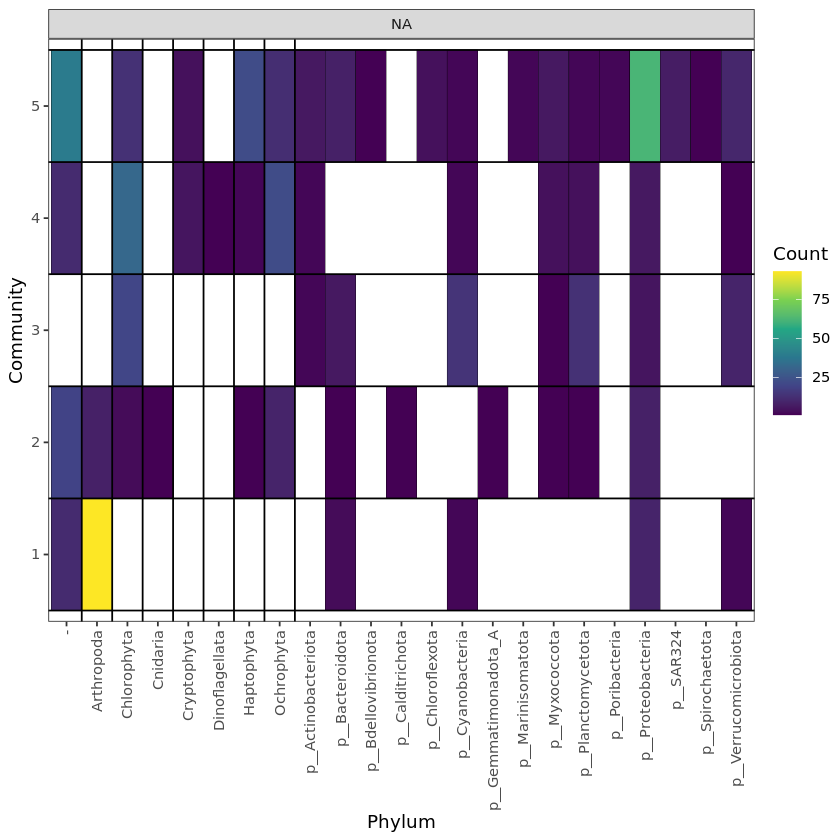

In [93]:
ggplot(layout_gr_classes %>%
                   dplyr::left_join(prokaryotic_taxonomy,by=c("mag"="new_mag_name")) %>%
                   dplyr::mutate(Phylum=case_when(Phylum=="NA"~Phylum_Bact,
                                                  TRUE ~ Phylum))) + 
    stat_bin2d(aes(x = Phylum, y = factor(community), fill = after_stat(count)),
                                       colour="black") + 
    facet_wrap(~Domain,scales="free_x") + theme_test() + 
    scale_fill_continuous(na.value = "white", type="viridis", name = "Count") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    geom_vline(xintercept=seq(1.5, length(unique(layout_gr_classes$Phylum))-0.5, 1), 
             lwd=0.5, colour="black") + 
    geom_hline(yintercept=seq(0.5, length(unique(layout_gr_classes$community))+0.5, 1), 
             lwd=0.5, colour="black") + 
    ylab("Community") + xlab("Phylum")

In [10]:
harriet_groups = read.csv("/vortexfs1/omics/alexander/halexander/2021-tara-final-paper/tables/final/TableS2_EukaryoticMAG.csv")
harriet_groups = harriet_groups %>% dplyr::select(X,groups) %>% dplyr::rename("harriet_groups"="groups")
harriet_groups

X,harriet_groups
<chr>,<chr>
TOPAZ_IOD1_E001,Cryptophyta
TOPAZ_IOD1_E002,SAR
TOPAZ_IOD1_E003,Haptophyta
TOPAZ_IOD1_E004,Haptophyta
TOPAZ_IOD1_E005,Chlorophyta
TOPAZ_IOD1_E006,SAR
TOPAZ_IOD1_E007,Cryptophyta
TOPAZ_IOD1_E008,SAR
TOPAZ_IOD1_E009,Chlorophyta


In [14]:
###Read in MAG data
HQ_Mags = read.csv(file.path("/vortexfs1/omics/alexander/akrinos/2021-03_Tara/2021-TOPAZ-MAG-Figures/notebooks/..","data","taxonomy_color_ranges.csv"), 
                   row.names=1)
test = HQ_Mags
EukMAGDF = read.csv(file.path("/vortexfs1/omics/alexander/akrinos/2021-03_Tara/2021-TOPAZ-MAG-Figures/notebooks/..","tables","final", 
                    'TableS2_EukaryoticMAG.csv'), row.names=1) %>% dplyr::mutate(new_mag_name=row.names(.))
translation_dict = read.csv('/vortexfs1/omics/alexander/halexander/2021-tara-final-paper/rename/renamed-eukaryotic-mags.tsv', sep='\t', 
                               row.names=1)
translation_dict_r = read.csv('/vortexfs1/omics/alexander/halexander/2021-tara-final-paper/rename/renamed-eukaryotic-mags.tsv', sep='\t', 
                                 row.names=1)
HQ_Mags = HQ_Mags %>% dplyr::mutate(old_mag_name = rownames(.)) %>% 
            dplyr::left_join(translation_dict %>%
                             mutate(old_mag_name = rownames(.)))
rownames(HQ_Mags) = HQ_Mags$new_mag_name
mmseqs_tax = read.csv(file.path("/vortexfs1/omics/alexander/akrinos/2021-03_Tara/2021-TOPAZ-MAG-Figures/notebooks/..","data",'mmseqs-taxonomy.tsv'),
                         sep='\t', row.names=1)
mmseqs_tax = mmseqs_tax %>% dplyr::mutate(old_mag_name = rownames(.)) %>% 
            dplyr::left_join(translation_dict %>%
                             mutate(old_mag_name = rownames(.)))
rownames(mmseqs_tax) = mmseqs_tax$new_mag_name
EukMAGDF['total_length_Mb'] = EukMAGDF$total_length/10^6
# Define broad plotting groups of taxa 
fungi_int = rownames(mmseqs_tax)[which(as.character(mmseqs_tax$kingdom)=='Fungi')]
sar = rownames(mmseqs_tax %>% dplyr::filter((kingdom == ".") & (clade == "Sar") & 
                                            (phylum == ".") & (class == ".")))
harriet_groups = read.csv("/vortexfs1/omics/alexander/halexander/2021-tara-final-paper/tables/final/TableS2_EukaryoticMAG.csv")
harriet_groups = harriet_groups %>% dplyr::select(X,groups) %>% dplyr::rename("harriet_groups"="groups")
EukMAGDF = EukMAGDF %>% #dplyr::mutate(new_mag_name=row.names(.)) %>%
                        dplyr::left_join(mmseqs_tax,by="new_mag_name") %>%
                        tidyr::separate(eukulele_taxonomy,into=c("tax0","tax1","tax2","tax3"),extra="drop",fill="right") %>%
                        tidyr::replace_na(list(tax1 = "-", tax2 = "-")) %>%
                        dplyr::mutate(groups=paste(tax1,tax2,sep=";")) %>%
                        dplyr::select(-c("tax0","tax1","tax2","tax3")) %>%
                        dplyr::mutate(groups_full = as.character(groups)) %>%
                        dplyr::mutate(groups = case_when(kingdom == "Fungi" ~ "Fungi",
                                                         grepl("Metazoa",groups_full) ~ "Metazoa",
                                                         grepl("Chlorophyta",groups_full) ~ "Chlorophyta",
                                                         grepl("Cryptophyta",groups_full) ~ "Cryptophyta",
                                                         grepl("Haptophyta",groups_full) ~ "Haptophyta",
                                                         grepl("Ochrophyta",groups_full) ~ "Ochrophyta",
                                                         (groups_full == "Alveolata;Ciliophora") ~ "Sar",
                                                         (groups_full == "Alveolata;Dinoflagellata") ~ "Sar",
                                                         (groups_full == "Stramenopiles;-") ~ "Sar",
                                                         (groups_full == "Stramenopiles;") ~ "Sar",
                                                          grepl("Amoebozoa",groups_full)  ~ "Amoebozoa",
                                                         ((kingdom == ".") & (clade == "Sar") & 
                                                         (phylum == ".") & (class == ".")) ~ "Sar",
                                                         (groups_full == "-;") ~ "Eukaryota",
                                                         (groups_full == "-;-") ~ "Eukaryota",
                                                         (groups_full == ";-") ~ "Eukaryota",
                                                         (clade == "Sar") ~ "Sar")) %>%
                      dplyr::mutate(groups = as.character(groups)) %>%
                      dplyr::left_join(harriet_groups,by = c("new_mag_name"="X")) %>%
                      dplyr::mutate(harriet_groups = as.character(harriet_groups)) %>%
                      dplyr::mutate(groups = case_when((harriet_groups != "") & !is.na(harriet_groups) ~ harriet_groups,
                                                       TRUE ~ groups))
EukMAGDF_HQ_all = EukMAGDF 
#EukMAGDF = EukMAGDF %>% dplyr::left_join(HQ_Mags,by=c("new_mag_name","old_mag_name")) %>% 
#                dplyr::filter(!is.na(color)) %>% distinct(groups,.keep_all=TRUE)
EukMAGDF_HQ = EukMAGDF %>% dplyr::left_join(HQ_Mags,by=c("new_mag_name","old_mag_name")) %>% 
                dplyr::filter(!is.na(color)) %>% distinct(groups,.keep_all=TRUE) %>% 
                mutate(across(everything(), as.character)) %>% 
                bind_rows(data.frame("new_mag_name"="","old_mag_name"="",
                                     "color"=c("#E66B92",
                                               '#FCDCFF',
                                               '#18AB7B',
                                               '#9A6ACD',
                                               '#BAAB1C'), #C6BE53'),
                                     "groups"=c('Amoebozoa',
                                                'Choanozoa',
                                                'Dinoflagellata',
                                                'Apusozoa',
                                                'Cryptophyta'))) %>%
                dplyr::mutate(color=case_when(groups=="Amoebozoa"~"#E66B92",
                                              groups=="Choanozoa"~'#FCDCFF',
                                              groups=='Dinoflagellata'~'#18AB7B',
                                              groups=='Apusozoa'~'#9A6ACD',
                                              groups=='Cryptophyta'~'#BAAB1C',
                                              TRUE ~ color))
                #bind_rows(data.frame("new_mag_name"="","old_mag_name"="",
                #                     "color"="#E66B92","groups"='Amoebozoa'))

EukMAGDF = EukMAGDF %>% dplyr::left_join(EukMAGDF_HQ %>% dplyr::select(color,groups))
#Read in pangea data
pangea = read.csv(file.path("/vortexfs1/omics/alexander/akrinos/2021-03_Tara/2021-TOPAZ-MAG-Figures/notebooks/..","data",'TARA_sample_enviro.tab'), 
                  sep ='\t', header=TRUE,skip=2508)
colnames(pangea) = c("Sample ID (TARA_barcode#)",
                     "Basis","Campaign","Station (TARA_station#)","Event","Event 2",
                     "Method/Device","Date/Time","Latitude","Longitude","Date/Time 2",
                     "Latitude 2","Longitude 2","Env feature (abbreviation)",
                     "Env feature (full name (ENVO:ID), terms re...)","MP biome (Longhurst (2007))",
                     "OS region ([abbreviation] full name (MRG...)",
                     "BG province ([abbreviation] full name (MRG...)",
                     "Depth ref [m] (in the selected environmental...)",
                     "Cond [mS/cm] (in the selected environmental...)",
                     "Sal (in the selected environmental...)",
                     "Tpot [°C] (in the selected environmental...)",
                     "Sigma-theta [kg/m**3] (in the selected environmental...)",
                     "O2 [µmol/kg] (in the selected environmental...)", 
                     "O2 [µmol/kg] (in the selected environmental...)",
                     "[NO3]- [µmol/l] (in the selected environmental...)",
                     "[NO2]- [µmol/l] (in the selected environmental...)",
                     "[PO4]3- [µmol/l] (in the selected environmental...)",
                     "[NO3]- + [NO2]- [µmol/l] (in the selected environmental...)",
                     "Si(OH)4 [µmol/l] (in the selected environmental...)",
                     "Chl a [mg/m**3] (in the selected environmental...)",
                     "Chl a [mg/m**3] (in the selected environmental...)",
                     "beta470 [m/sr] (in the selected environmental...)",
                     "beta470 [m/sr] (in the selected environmental...)",
                     "beta470 [m/sr] (in the selected environmental...)",
                     "bb470 [1/m] (in the selected environmental...)",
                     "bbp470 [1/m] (in the selected environmental...)",
                     "fCDOM [ppb (QSE)] (in the selected environmental...)",
                     "bac660 [1/m] (in the selected environmental...)",
                     "bacp660 [1/m] (in the selected environmental...)",
                     "fCDOM [ppb (QSE)] (at the sampling location, exp...)",
                     "PAR day [mol quanta/m**2/day] (for a period of 8 days around...)",
                     "PAR day [mol quanta/m**2/day] (for a period of 30 days aroun...)",
                     "NPP C [mg/m**2/day] (for a period of 8 days around...)",
                     "NPP C [mg/m**2/day] (for a period of 30 days aroun...)",
                     "MLD [m] (in the selected environmental...)",
                     "MLD [m] (in the selected environmental...)",
                     "D chl m [m] (in the selected environmental...)",
                     "Depth max Brunt Väisälä freq [m] (in the selected environmental...)",
                     "Depth max O2 [m] (in the selected environmental...)",
                     "Depth min O2 [m] (in the selected environmental...)",
                     "Depth nitracline [m] (in the selected environmental...)",
                     "Season (spring, summer, autumn, or wi...)",
                     "Season (early, middle, or late)",
                     "Moon phase proportion (indicates if the phase of the...)",
                     "Moon phase proportion (indicates the proportion of i...)",
                     "SSD [min] (day length)",
                     "u [cm/s] (Calculated (d'Ovidio et al. 2...)",
                     "v [cm/s] (Calculated (d'Ovidio et al. 2...)",
                     "OW (indicates the presence of an ...)",
                     "MLE [1/day] (indicates the presence of a t...)",
                     "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)",
                     "RT [days] (of the water mass. Values>30 ...)")
colnames(pangea) = c("TaraBarcode",
                     "Basis","Campaign","Station (TARA_station#)","Event","Event 2",
                     "Method/Device","Date/Time","Latitude","Longitude","Date/Time 2",
                     "Latitude 2","Longitude 2","Env feature (abbreviation)",
                     "Env feature (full name (ENVO:ID), terms re...)","MP biome (Longhurst (2007))",
                     "Region",
                     "BG province ([abbreviation] full name (MRG...)",
                     "Depth ref [m] (in the selected environmental...)",
                     "Cond [mS/cm] (in the selected environmental...)",
                     "Sal",
                     "Tpot [°C] (in the selected environmental...)",
                     "Sigma-theta [kg/m**3] (in the selected environmental...)",
                     "O2 [µmol/kg] (in the selected environmental...)",
                     "O2",
                     "Nitrate",
                     "Nitrite",
                     "Phosphate",
                     "Nitrate+Nitrite",
                     "Silica",
                     "Chl a [mg/m**3] (in the selected environmental...)",
                     "Chla",
                     "beta470 [m/sr] (in the selected environmental...)",
                     "beta470 [m/sr] (in the selected environmental...)1",
                     "beta470 [m/sr] (in the selected environmental...)2",
                     "bb470 [1/m] (in the selected environmental...)",
                     "bbp470 [1/m] (in the selected environmental...)",
                     "fCDOM [ppb (QSE)] (in the selected environmental...)",
                     "bac660 [1/m] (in the selected environmental...)",
                     "bacp660 [1/m] (in the selected environmental...)",
                     "fCDOM [ppb (QSE)] (at the sampling location, exp...)",
                     "PAR day [mol quanta/m**2/day] (for a period of 8 days around...)",
                     "PAR day [mol quanta/m**2/day] (for a period of 30 days aroun...)",
                     "NPP C [mg/m**2/day] (for a period of 8 days around...)",
                     "NPP",
                     "MLD [m] (in the selected environmental...)",
                     "MLD [m] (in the selected environmental...)1",
                     "D chl m [m] (in the selected environmental...)",
                     "Depth max Brunt Väisälä freq [m] (in the selected environmental...)",
                     "Depth max O2 [m] (in the selected environmental...)",
                     "Depth min O2 [m] (in the selected environmental...)",
                     "Depth nitracline [m] (in the selected environmental...)",
                     "Season",
                     "Season (early, middle, or late)",
                     "Moon phase proportion (indicates if the phase of the...)",
                     "Moon phase proportion (indicates the proportion of i...)",
                     "SSD",
                     "u [cm/s] (Calculated (d'Ovidio et al. 2...)",
                     "v [cm/s] (Calculated (d'Ovidio et al. 2...)",
                     "OW (indicates the presence of an ...)",
                     "MLE [1/day] (indicates the presence of a t...)",
                     "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)",
                     "RT")

ena_table = read.csv(file.path('/vortexfs1/omics/alexander/akrinos/2021-03_Tara/2021-TOPAZ-MAG-Figures/notebooks/..','data','PRJEB4352_metaG.txt'), sep='\t')
ena_data = ena_table %>% dplyr::inner_join(pangea %>% dplyr::mutate(sample_alias = TaraBarcode)) 
rownames(ena_data) = ena_data$run_accession
errdf = read.csv(file.path('/vortexfs1/omics/alexander/akrinos/2021-03_Tara/2021-TOPAZ-MAG-Figures/notebooks/..','data','SampleList_2020_metaG.txt'), sep='\t')
errnewdf = errdf %>% dplyr::mutate(ERR_list = as.character(ERR_list)) %>%
                     tidyr::separate_rows(ERR_list, sep=",") %>%
                     dplyr::mutate(Depth_sizefrac = as.character(Depth_sizefrac)) %>%
                     tidyr::separate(Depth_sizefrac,into=c("region","depth","sf"),sep="-",extra="drop") 
#read in metagenomic abundance
tpm_df = read.csv(file.path('/vortexfs1/omics/alexander/akrinos/2021-03_Tara/tara-networks/input/MAG_tpm_new_approach.csv'), row.names=1) %>% 
            dplyr::mutate(new_mag_name = Genome) %>% 
            dplyr::left_join(translation_dict %>% mutate(old_mag_name = rownames(.))) %>%
            dplyr::filter(new_mag_name %in% as.character(EukMAGDF_HQ_all$new_mag_name))

Joining, by = "old_mag_name"
Joining, by = "old_mag_name"
Joining, by = "groups"
Joining, by = "sample_alias"
Joining, by = "new_mag_name"


In [16]:
#### MERGE WITH HARRIET'S ENVIRONMENTAL DATA FROM ABOVE####
mag_info = read.csv(file.path("/vortexfs1/omics/alexander/akrinos/2021-03_Tara/2021-TOPAZ-MAG-Figures/notebooks/..","data","heterotrophy_burns.csv"))
mag_info_class =  mag_info %>% dplyr::left_join(translation_dict%>%dplyr::mutate(old_mag_name=
                                                                                 rownames(.)),
                                                                                 by=c("MAGs"="old_mag_name")) %>%
    dplyr::mutate(MAGs=new_mag_name) %>%
    dplyr::mutate(Classifications = get_tax_string_no_cluster(MAGs)) %>%
    tidyr::separate(Classifications, sep = ";", fill = "left",
                    c("Domain","Supergroup","Phylum","Class",
                             "Order","Family","Genus","Species"))

mag_info_euks = EukMAGDF %>% dplyr::inner_join(mag_info_class %>%
                                               dplyr::select(new_mag_name,
                                                             Domain,
                                                             Phylum,
                                                             Class,
                                                             Order,
                                                             Family,
                                                             Genus,
                                                             Species) %>%
                                               dplyr::distinct(), by = c("new_mag_name")) %>%
                dplyr::rename("Genome"="old_mag_name") %>% dplyr::distinct()

euk_mag_df = mag_info_euks %>% dplyr::left_join(tpm_df,by="new_mag_name")

metadata_melted = euk_mag_df %>% dplyr::select(starts_with("ERR"),"new_mag_name",
                             "groups","color","old_mag_name","Domain","Phylum","Order") %>% 
    tidyr::gather(key="Station",value="TPM", -c("new_mag_name","old_mag_name","groups","color",
                                                "Domain","Phylum","Order"))

metadata_mega = metadata_melted %>% 
    dplyr::left_join(ena_data,by=c("Station"="run_accession")) %>%
    dplyr::left_join(errnewdf %>% dplyr::mutate(ERR_list = trimws(ERR_list),
                                                depth = as.numeric(as.character(depth)),
                                                sf = as.numeric(as.character(sf))),
                                                by=c("Station"="ERR_list")) %>%
    dplyr::rename()

combined_clust_info = layout_gr %>% #dplyr::left_join(layout_gr,cluster_groups,
    #by=c("mag"="Cluster","classification")) %>%
    dplyr::mutate("Cluster" = mag) %>%
    dplyr::mutate("MAG" = mag)

combined_all_enviro = dplyr::left_join(metadata_mega,combined_clust_info %>% 
                                       dplyr::select(community,Cluster,MAG),
                                       by = c("old_mag_name" = "MAG")) %>%
                      dplyr::mutate(depth=as.numeric(as.character(depth)))

cluster_summed_station = combined_all_enviro %>% 
                            dplyr::mutate(TPM = as.numeric(as.character(TPM))) %>%
                            dplyr::group_by(Station,community,region,Cluster,sf) %>% 
                            dplyr::summarize(groupedAbund = sum(TPM))

corr_df = metadata_melted %>%
    group_by(groups,Station) %>%
    dplyr::summarize(TPM = sum(TPM)) %>%
    dplyr::left_join(ena_data,by=c("Station"="run_accession")) %>%
    dplyr::left_join(errnewdf %>% dplyr::mutate(ERR_list = trimws(ERR_list),
                                                depth = as.numeric(as.character(depth)),
                                                sf = as.numeric(as.character(sf))),
                                                by=c("Station"="ERR_list")) 

Warning message:
“Expected 8 pieces. Additional pieces discarded in 485 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
`summarise()` has grouped output by 'Station', 'community',
'region', 'Cluster'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'groups'. You can override
using the `.groups` argument.


In [17]:
options(warn=-1)
all_df = data.frame()
vars_ofinterest = c('Depth ref [m] (in the selected environmental...)',
 'Sal',
 'Tpot [°C] (in the selected environmental...)',
 'Sigma-theta [kg/m**3] (in the selected environmental...)',
 "O2",
 #"Nitrate",
 #"Nitrite",
 "Phosphate",
 "Nitrate+Nitrite",
 "Silica",
 "Chla",
 'Chl a [mg/m**3] (in the selected environmental...)',
 'bbp470 [1/m] (in the selected environmental...)',
 'fCDOM [ppb (QSE)] (in the selected environmental...)',
 'bacp660 [1/m] (in the selected environmental...)',
 'fCDOM [ppb (QSE)] (at the sampling location, exp...)',
 'PAR day [mol quanta/m**2/day] (for a period of 8 days around...)',
  "NPP",
 'MLD [m] (in the selected environmental...)',
 'D chl m [m] (in the selected environmental...)',
 'Depth max Brunt Väisälä freq [m] (in the selected environmental...)',
 'Depth max O2 [m] (in the selected environmental...)',
 'Depth nitracline [m] (in the selected environmental...)',
 'SSD',
 "u [cm/s] (Calculated (d'Ovidio et al. 2...)",
 "v [cm/s] (Calculated (d'Ovidio et al. 2...)",
 'OW (indicates the presence of an ...)',
 'MLE [1/day] (indicates the presence of a t...)',
 "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)",
 'RT')
for (var in vars_ofinterest) {
    current_df = metadata_melted %>%
        dplyr::left_join(combined_clust_info %>% 
                         dplyr::select(community,Cluster,MAG),#,HClustCluster),
                         by = c("new_mag_name" = "MAG")) %>%
        group_by(Station,groups,community) %>% #groups
        dplyr::summarize(TPM = sum(TPM)) %>% 
        dplyr::left_join(ena_data,by=c("Station"="run_accession")) %>%
        dplyr::left_join(errnewdf %>% dplyr::mutate(ERR_list = trimws(ERR_list),
                                                    depth = as.numeric(as.character(depth)),
                                                    sf = as.numeric(as.character(sf))),
                                                    by=c("Station"="ERR_list")) %>%
        dplyr::filter(!is.na(!!as.symbol(var)) & !(is.na(TPM))) %>%
        group_by(community,groups) %>% #groups
        dplyr::summarize(Cor=cor(!!as.symbol(var),TPM,use = "complete.obs",method="spearman"),
                         Cor_Pval=cor.test(!!as.symbol(var),TPM,method="spearman")$p.value) %>% 
        dplyr::mutate(community = (as.character(community))) %>%
        dplyr::mutate(Cor_Var = var)
    all_df = all_df %>% dplyr::bind_rows(current_df)
}
all_df$Cor_Pval = p.adjust(all_df$Cor_Pval, method = "bonferroni", n = length(all_df$Cor_Pval))
                           #p.adjust.methods, n = length(all_df$Cor_Pval))
options(warn=0)

`summarise()` has grouped output by 'Station', 'groups'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'community'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'Station', 'groups'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'community'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'Station', 'groups'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'community'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'Station', 'groups'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'community'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'Station', 'groups'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'community'. You can override
using the `.groups` argument.


In [21]:
all_df_old = all_df

Warning message:
“Removed 430 rows containing missing values (geom_point).”
Warning message:
“Removed 430 rows containing missing values (geom_point).”


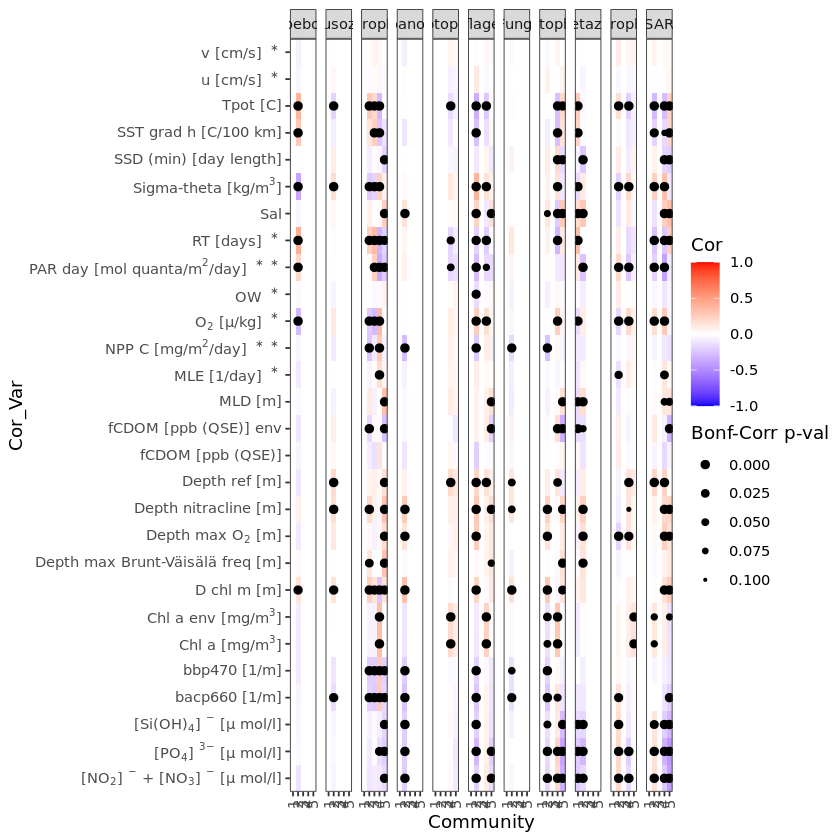

In [23]:
all_df = all_df_old %>% dplyr::mutate(Cor_Var = case_when(Cor_Var == 
                                             "PAR day [mol quanta/m**2/day] (for a period of 8 days around...)" ~ 
                             "PAR day \\[mol quanta/m$^2$/day\\] $^{**}$",
                             Cor_Var == "MLD [m] (in the selected environmental...)" ~ 
                             "MLD \\[m\\]",
                             Cor_Var == "u [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ 
                             "u \\[cm/s\\] $^{*}$",
                             Cor_Var == "v [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ "v \\[cm/s\\] $^{*}$",
                             Cor_Var == "fCDOM [ppb (QSE)] (at the sampling location, exp...)" ~ 
                             "fCDOM \\[ppb (QSE)\\]",
                             Cor_Var == "NPP" ~ 
                             "NPP C \\[mg/m$^2$/day\\] $^{**}$",
                             Cor_Var == "Nitrate" ~ 
                             "\\[NO_3\\] $^{-}$ \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Silica" ~ 
                             "\\[Si(OH)$_4$\\] $^{-}$ \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Phosphate" ~ 
                             "\\[PO$_4$\\] $^{3-}$ \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Nitrite" ~ 
                             "\\[NO$_2$\\] $^{-}$ \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Nitrate+Nitrite" ~ 
                             "\\[NO$_2$\\] $^{-}$ + \\[NO$_3$\\] $^{-}$ \\[$\\mu$ mol/l\\]",
                             Cor_Var == "bbp470 [1/m] (in the selected environmental...)" ~ 
                             "bbp470 \\[1/m\\]",
                             Cor_Var == "bacp660 [1/m] (in the selected environmental...)" ~ 
                             "bacp660 \\[1/m\\]",
                             Cor_Var == "Sigma-theta [kg/m**3] (in the selected environmental...)" ~ 
                             "Sigma-theta \\[kg/$m^3$\\]",
                             Cor_Var == "fCDOM [ppb (QSE)] (in the selected environmental...)" ~ 
                             "fCDOM \\[ppb (QSE)\\] env",
                             Cor_Var == "OW (indicates the presence of an ...)" ~ 
                             "OW $^*$",
                             Cor_Var == "Depth ref [m] (in the selected environmental...)" ~ 
                             "Depth ref \\[m\\]",
                             Cor_Var == "Chla" ~ 
                             "Chl a env \\[mg/m$^3$\\]",
                             Cor_Var == "Chl a [mg/m**3] (in the selected environmental...)" ~ 
                             "Chl a \\[mg/m$^3$\\]",
                             Cor_Var == "RT" ~ 
                             "RT \\[days\\] $^{*}$",
                             Cor_Var == "O2" ~ 
                             "O$_2$ \\[$\\mu$/kg\\] $^{*}$",
                             Cor_Var == "SSD" ~ 
                             "SSD (min) \\[day length\\]",
                             Cor_Var == "Tpot [°C] (in the selected environmental...)" ~ "Tpot \\[$^o$C\\]",
                             Cor_Var == "D chl m [m] (in the selected environmental...)" ~ "D chl m \\[m\\]",  
                             Cor_Var == "Depth max Brunt Väisälä freq [m] (in the selected environmental...)" ~ 
                                             "Depth max Brunt-Väisälä freq \\[m\\]",             
                             Cor_Var == "Depth max O2 [m] (in the selected environmental...)" ~ 
                                             "Depth max O$_2$ \\[m\\]",                 
                             #Cor_Var == "Depth min O2 [m] (in the selected environmental...)" ~ 
                             #                "Min O2 depth",               
                             Cor_Var == "Depth nitracline [m] (in the selected environmental...)" ~ 
                                             "Depth nitracline \\[m\\]",        
                             Cor_Var == "MLE [1/day] (indicates the presence of a t...)" ~ "MLE \\[1/day\\] $^{*}$",
                             Cor_Var == "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)" ~ 
                                                               "SST grad h \\[$^o$C/100 km\\]",
                         TRUE ~ Cor_Var))
pacman::p_load(latex2exp)
ggplot(all_df %>% dplyr::mutate(community = (as.character(community))) %>% 
        dplyr::mutate(Community = case_when(!is.na(community) ~ community,
                                            TRUE ~ "NoCommunity")) %>%
        dplyr::filter(Community != "NoCommunity") %>%
        dplyr::mutate(Community = factor(Community,levels=as.character(c(1:11))))) + 
    geom_tile(aes(x=Community,y=Cor_Var,fill=Cor)) +
    geom_point(aes(x=Community,y=Cor_Var,size=Cor_Pval)) +
    scale_fill_gradient2(limits=c(-1,1),high = "red", low = "blue") +
    #scale_size_area(limits = c(0,0.1), breaks = c(0,0.049,0.1),
    #                labels=c("HighSig","Significant","MarginallySig"),
    #                name = "Bonf-Corr p-val") +
    scale_size(trans = 'reverse',limits=c(0.1,0),range=c(0.5,2),name = "Bonf-Corr p-val") +
    facet_wrap(~groups,nrow=1) +
    theme_test() +
    scale_y_discrete(breaks = all_df$Cor_Var, 
        labels = parse(text=latex2exp::TeX(all_df$Cor_Var, output="character")), #str2expression(all_df$Cor_Var),
        #parse(text=levels(dendro_env_labels$label)),
        expand = c(0, 0)) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
ggsave(file.path("..","figures","bygroup_new.png"),width=17,height=6,units="in",dpi=350)

In [24]:
options(warn=-1)

all_df = data.frame()
for (var in vars_ofinterest) {
    current_df = metadata_melted %>%
        dplyr::left_join(combined_clust_info %>% 
                         dplyr::select(community,Cluster,MAG),#,HClustCluster),
                         by = c("new_mag_name" = "MAG")) %>%
        group_by(Station,community) %>% #groups
        dplyr::summarize(TPM = sum(TPM,na.rm=T)) %>% 
        dplyr::left_join(ena_data,by=c("Station"="run_accession")) %>%
        dplyr::left_join(errnewdf %>% dplyr::mutate(ERR_list = trimws(ERR_list),
                                                    depth = as.numeric(as.character(depth)),
                                                    sf = as.numeric(as.character(sf))),
                                                    by=c("Station"="ERR_list")) %>%
        dplyr::filter(!is.na(!!as.symbol(var)) & !(is.na(TPM))) %>%
        group_by(community) %>% #groups
        dplyr::summarize(Cor=cor(!!as.symbol(var),TPM,use = "complete.obs",method="spearman"),
                         Cor_Pval=cor.test(!!as.symbol(var),TPM,method="spearman")$p.value) %>% 
        dplyr::mutate(community = (as.character(community))) %>%
        dplyr::mutate(Cor_Var = var)
    all_df = all_df %>% dplyr::bind_rows(current_df)
}
all_df$Cor_Pval = p.adjust(all_df$Cor_Pval, method = p.adjust.methods, n = length(all_df$Cor_Pval))
options(warn=0)

`summarise()` has grouped output by 'Station'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'Station'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'Station'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'Station'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'Station'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'Station'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'Station'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'Station'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'Station'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'Station'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'Station'. You can overr

In [25]:
all_df_test = all_df %>% dplyr::mutate(Cor_Var = case_when(Cor_Var == 
                                             "PAR day [mol quanta/m**2/day] (for a period of 8 days around...)" ~ 
                             "PAR - 8",
                             Cor_Var == "MLD [m] (in the selected environmental...)" ~ 
                             "MLD",
                             Cor_Var == "u [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ 
                             "u",
                             Cor_Var == "v [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ "v",
                             Cor_Var == "fCDOM [ppb (QSE)] (at the sampling location, exp...)" ~ 
                             "fCDOM",
                             Cor_Var == "bbp470 [1/m] (in the selected environmental...)" ~ 
                             "bbp470",
                             Cor_Var == "bacp660 [1/m] (in the selected environmental...)" ~ 
                             "bacp660",
                             Cor_Var == "Sigma-theta [kg/m**3] (in the selected environmental...)" ~ 
                             "Sigma-theta",
                             Cor_Var == "fCDOM [ppb (QSE)] (in the selected environmental...)" ~ 
                             "fCDOM Env",
                             Cor_Var == "OW (indicates the presence of an ...)" ~ 
                             "OW",
                             Cor_Var == "Depth ref [m] (in the selected environmental...)" ~ 
                             "Depth (ref)",
                             Cor_Var == "Chl a [mg/m**3] (in the selected environmental...)" ~ 
                             "Chla Env",
                             Cor_Var == "Tpot [°C] (in the selected environmental...)" ~ "Tpot",
                             Cor_Var == "D chl m [m] (in the selected environmental...)" ~ "D chl m",  
                             Cor_Var == "Depth max Brunt Väisälä freq [m] (in the selected environmental...)" ~ 
                                             "Brunt-Väisälä depth",             
                             Cor_Var == "Depth max O2 [m] (in the selected environmental...)" ~ 
                                             "Max O2 depth",                 
                             #Cor_Var == "Depth min O2 [m] (in the selected environmental...)" ~ 
                             #                "Min O2 depth",               
                             Cor_Var == "Depth nitracline [m] (in the selected environmental...)" ~ 
                                             "Nitracline depth",        
                             Cor_Var == "MLE [1/day] (indicates the presence of a t...)" ~ "MLE",
                             Cor_Var == "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)" ~ "SST",
                         TRUE ~ Cor_Var))

all_df = all_df %>% dplyr::mutate(Cor_Var = case_when(Cor_Var == 
                                             "PAR day [mol quanta/m**2/day] (for a period of 8 days around...)" ~ 
                             "PAR day \\[mol quanta/m$^2$/day\\] $^{**}$",
                             Cor_Var == "MLD [m] (in the selected environmental...)" ~ 
                             "MLD \\[m\\]",
                             Cor_Var == "u [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ 
                             "u \\[cm/s\\] $^{*}$",
                             Cor_Var == "v [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ "v \\[cm/s\\] $^{*}$",
                             Cor_Var == "fCDOM [ppb (QSE)] (at the sampling location, exp...)" ~ 
                             "fCDOM \\[ppb (QSE)\\]",
                             Cor_Var == "NPP" ~ 
                             "NPP C \\[mg/m$^2$/day\\] $^{**}$",
                             Cor_Var == "Nitrate" ~ 
                             "\\[NO_3\\] $^{-}$ \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Silica" ~ 
                             "\\[Si(OH)$_4$\\] $^{-}$ \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Phosphate" ~ 
                             "\\[PO$_4$\\] $^{3-}$ \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Nitrite" ~ 
                             "\\[NO$_2$\\] $^{-}$ \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Nitrate+Nitrite" ~ 
                             "\\[NO$_2$\\] $^{-}$ + \\[NO$_3$\\] $^{-}$ \\[$\\mu$ mol/l\\]",
                             Cor_Var == "bbp470 [1/m] (in the selected environmental...)" ~ 
                             "bbp470 \\[1/m\\]",
                             Cor_Var == "bacp660 [1/m] (in the selected environmental...)" ~ 
                             "bacp660 \\[1/m\\]",
                             Cor_Var == "Sigma-theta [kg/m**3] (in the selected environmental...)" ~ 
                             "Sigma-theta \\[kg/$m^3$\\]",
                             Cor_Var == "fCDOM [ppb (QSE)] (in the selected environmental...)" ~ 
                             "fCDOM \\[ppb (QSE)\\] env",
                             Cor_Var == "OW (indicates the presence of an ...)" ~ 
                             "OW $^*$",
                             Cor_Var == "Depth ref [m] (in the selected environmental...)" ~ 
                             "Depth ref \\[m\\]",
                             Cor_Var == "Chla" ~ 
                             "Chl a env \\[mg/m$^3$\\]",
                             Cor_Var == "Chl a [mg/m**3] (in the selected environmental...)" ~ 
                             "Chl a \\[mg/m$^3$\\]",
                             Cor_Var == "RT" ~ 
                             "RT \\[days\\] $^{*}$",
                             Cor_Var == "O2" ~ 
                             "O$_2$ \\[$\\mu$/kg\\] $^{*}$",
                             Cor_Var == "SSD" ~ 
                             "SSD (min) \\[day length\\]",
                             Cor_Var == "Tpot [°C] (in the selected environmental...)" ~ "Tpot \\[$^o$C\\]",
                             Cor_Var == "D chl m [m] (in the selected environmental...)" ~ "D chl m \\[m\\]",  
                             Cor_Var == "Depth max Brunt Väisälä freq [m] (in the selected environmental...)" ~ 
                                             "Depth max Brunt-Väisälä freq \\[m\\]",             
                             Cor_Var == "Depth max O2 [m] (in the selected environmental...)" ~ 
                                             "Depth max O$_2$ \\[m\\]",                 
                             #Cor_Var == "Depth min O2 [m] (in the selected environmental...)" ~ 
                             #                "Min O2 depth",               
                             Cor_Var == "Depth nitracline [m] (in the selected environmental...)" ~ 
                                             "Depth nitracline \\[m\\]",        
                             Cor_Var == "MLE [1/day] (indicates the presence of a t...)" ~ "MLE \\[1/day\\] $^{*}$",
                             Cor_Var == "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)" ~ 
                                                               "SST grad h \\[$^o$C/100 km\\]",
                         TRUE ~ Cor_Var))

corr_comm_only = ggplot(all_df %>% dplyr::mutate(community = (as.character(community))) %>% 
        dplyr::mutate(Community = case_when(!is.na(community) ~ community,
                                            TRUE ~ "NoCommunity")) %>%
        dplyr::filter(Community != "NoCommunity")) + 
    geom_tile(aes(x=Community,y=Cor_Var,fill=Cor)) +
    geom_point(aes(x=Community,y=Cor_Var,size=Cor_Pval)) +
    scale_fill_gradient2(limits=c(-1,1),high = "red", low = "blue",name="Correlation") +
    scale_size(trans = 'reverse',limits=c(0.1,0),range=c(0.5,2),name = "Bonferroni\np-val") +
    theme_test() +
    scale_y_discrete(breaks = all_df$Cor_Var, 
        labels = parse(text=latex2exp::TeX(all_df$Cor_Var, output="character")), #str2expression(all_df$Cor_Var),
        #parse(text=levels(dendro_env_labels$label)),
        expand = c(0, 0))+
    ylab("") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

Warning message:
“Removed 76 rows containing missing values (geom_point).”


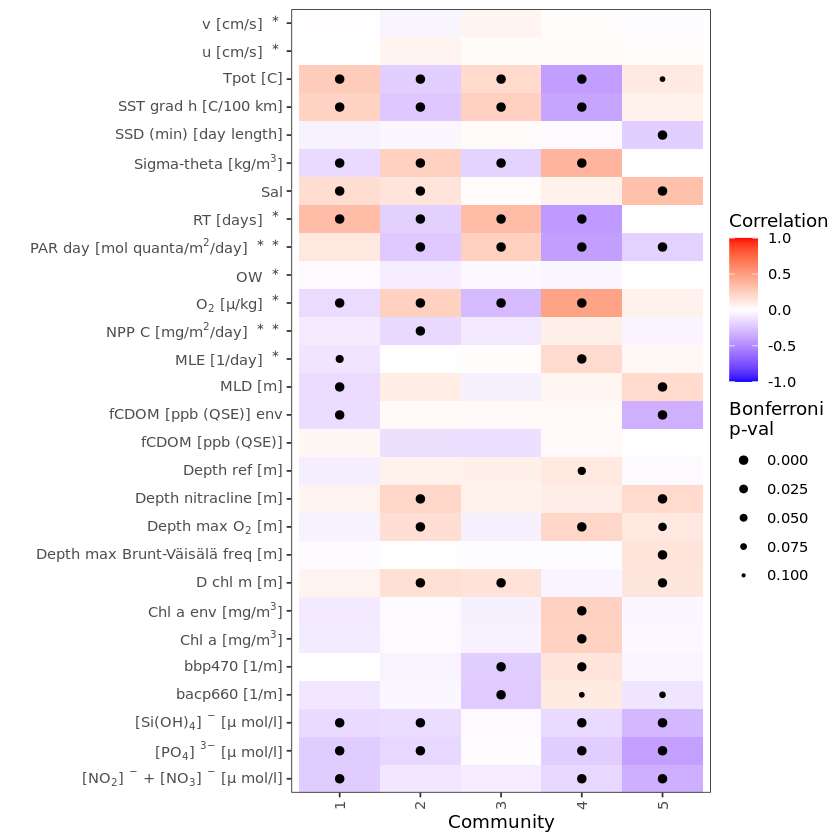

In [26]:
corr_comm_only

In [29]:
community_station_data = metadata_melted %>%
        dplyr::left_join(combined_clust_info %>% 
                         dplyr::select(community,Cluster,MAG),#,HClustCluster),
                         by = c("new_mag_name" = "MAG")) %>%
        group_by(Station,community) %>% #groups
        dplyr::summarize(TPM = sum(TPM)) %>%
        dplyr::filter(!is.na(community))

corr_df = community_station_data %>% dplyr::filter(!is.na(community)) %>%
    pivot_wider(id_cols = Station, names_from = community, values_from = TPM) %>% 
    column_to_rownames(var = "Station")

`summarise()` has grouped output by 'Station'. You can override
using the `.groups` argument.


In [32]:
environmental_station_data_byclust = metadata_melted %>% dplyr::filter(!is.na(TPM)) %>%
        dplyr::left_join(combined_clust_info %>% 
                         dplyr::select(community,Cluster,MAG),#,HClustCluster),
                         by = c("old_mag_name" = "MAG")) %>%
        dplyr::left_join(ena_data,by=c("Station"="run_accession")) %>%
        dplyr::left_join(errnewdf %>% dplyr::mutate(ERR_list = trimws(ERR_list),
                                                    depth = as.numeric(as.character(depth)),
                                                    sf = as.numeric(as.character(sf))),
                                                    by=c("Station"="ERR_list")) %>%
        dplyr::filter(!is.na(TPM)) %>%
        group_by(Station) %>% #groups
        dplyr::summarize_if(is.numeric,mean,na.rm=TRUE) %>% 
        #dplyr::summarize_if(is.numeric,sum) %>% 
        dplyr::select(c(vars_ofinterest,"Station")) %>%
        pivot_longer(names_to = "Cor_Var",values_to="TPM",cols=-c("Station"))
environmental_station_data_byclust_no = environmental_station_data_byclust %>% 
                             dplyr::mutate(Cor_Var = case_when(Cor_Var == 
                                             "PAR day [mol quanta/m**2/day] (for a period of 8 days around...)" ~ 
                             "PAR day \\[mol quanta/m^2/day\\]^{**}",
                             Cor_Var == "MLD [m] (in the selected environmental...)" ~ 
                             "MLD \\[m\\]",
                             Cor_Var == "u [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ 
                             "u \\[cm/s\\]^{*}",
                             Cor_Var == "v [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ "v \\[cm/s\\]^{*}",
                             Cor_Var == "fCDOM [ppb (QSE)] (at the sampling location, exp...)" ~ 
                             "fCDOM \\[ppb (QSE)\\]",
                             Cor_Var == "NPP" ~ 
                             "NPP C \\[mg/m^2/day\\] ^{**}",
                             Cor_Var == "Nitrate" ~ 
                             "\\[NO_3\\]^- \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Silica" ~ 
                             "\\[Si(OH)_4\\]^- \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Phosphate" ~ 
                             "\\[PO_4\\]^{3-} \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Nitrite" ~ 
                             "\\[NO_2\\]^- \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Nitrate+Nitrite" ~ 
                             "\\[NO_2\\]^- + \\[NO_3\\]^- \\[$\\mu$ mol/l\\]",
                             Cor_Var == "bbp470 [1/m] (in the selected environmental...)" ~ 
                             "bbp470 \\[1/m\\]",
                             Cor_Var == "bacp660 [1/m] (in the selected environmental...)" ~ 
                             "bacp660 \\[1/m\\]",
                             Cor_Var == "Sigma-theta [kg/m**3] (in the selected environmental...)" ~ 
                             "Sigma-theta \\[kg/m^3\\]",
                             Cor_Var == "fCDOM [ppb (QSE)] (in the selected environmental...)" ~ 
                             "fCDOM \\[ppb (QSE)\\] env",
                             Cor_Var == "OW (indicates the presence of an ...)" ~ 
                             "OW ^*",
                             Cor_Var == "Depth ref [m] (in the selected environmental...)" ~ 
                             "Depth ref \\[m\\]",
                             Cor_Var == "RT" ~ 
                             "RT \\[days\\]^*",
                             Cor_Var == "O2" ~ 
                             "O_2 \\[$\\mu$/kg\\]^*",
                             Cor_Var == "SSD" ~ 
                             "SSD (min) \\[day length\\]",
                             Cor_Var == "Chla" ~ 
                             "Chl a env \\[mg/m^3\\]",
                             Cor_Var == "Chl a [mg/m**3] (in the selected environmental...)" ~ 
                             "Chl a \\[mg/m^3\\]",
                             Cor_Var == "Tpot [°C] (in the selected environmental...)" ~ "Tpot \\[^oC\\]",
                             Cor_Var == "D chl m [m] (in the selected environmental...)" ~ "D chl m \\[m\\]",  
                             Cor_Var == "Depth max Brunt Väisälä freq [m] (in the selected environmental...)" ~ 
                                             "Depth max Brunt-Väisälä freq \\[m\\]",             
                             Cor_Var == "Depth max O2 [m] (in the selected environmental...)" ~ 
                                             "Depth max O_2 \\[m\\]",                 
                             #Cor_Var == "Depth min O2 [m] (in the selected environmental...)" ~ 
                             #                "Min O2 depth",               
                             Cor_Var == "Depth nitracline [m] (in the selected environmental...)" ~ 
                                             "Depth nitracline \\[m\\]",        
                             Cor_Var == "MLE [1/day] (indicates the presence of a t...)" ~ "MLE \\[1/day\\]^*",
                             Cor_Var == "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)" ~ 
                                                               "SST grad h \\[^oC/100 km\\]",
                         TRUE ~ Cor_Var)) %>%
                pivot_wider(id_cols = "Station", names_from = "Cor_Var", values_from = "TPM")
environmental_station_data_byclust = environmental_station_data_byclust %>% dplyr::mutate(Cor_Var = case_when(Cor_Var == 
                                             "PAR day [mol quanta/m**2/day] (for a period of 8 days around...)" ~ 
                             "PAR day \\[mol quanta/m$^2$/day\\] $^{**}$",
                             Cor_Var == "MLD [m] (in the selected environmental...)" ~ 
                             "MLD \\[m\\]",
                             Cor_Var == "u [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ 
                             "u \\[cm/s\\] $^{*}$",
                             Cor_Var == "v [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ "v \\[cm/s\\] $^{*}$",
                             Cor_Var == "fCDOM [ppb (QSE)] (at the sampling location, exp...)" ~ 
                             "fCDOM \\[ppb (QSE)\\]",
                             Cor_Var == "NPP" ~ 
                             "NPP C \\[mg/m$^2$/day\\] $^{**}$",
                             Cor_Var == "Nitrate" ~ 
                             "\\[NO_3\\] $^{-}$ \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Silica" ~ 
                             "\\[Si(OH)$_4$\\] $^{-}$ \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Phosphate" ~ 
                             "\\[PO$_4$\\] $^{3-}$ \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Nitrite" ~ 
                             "\\[NO$_2$\\] $^{-}$ \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Nitrate+Nitrite" ~ 
                             "\\[NO$_2$\\] $^{-}$ + \\[NO$_3$\\] $^{-}$ \\[$\\mu$ mol/l\\]",
                             Cor_Var == "bbp470 [1/m] (in the selected environmental...)" ~ 
                             "bbp470 \\[1/m\\]",
                             Cor_Var == "bacp660 [1/m] (in the selected environmental...)" ~ 
                             "bacp660 \\[1/m\\]",
                             Cor_Var == "Sigma-theta [kg/m**3] (in the selected environmental...)" ~ 
                             "Sigma-theta \\[kg/$m^3$\\]",
                             Cor_Var == "fCDOM [ppb (QSE)] (in the selected environmental...)" ~ 
                             "fCDOM \\[ppb (QSE)\\] env",
                             Cor_Var == "OW (indicates the presence of an ...)" ~ 
                             "OW $^*$",
                             Cor_Var == "Depth ref [m] (in the selected environmental...)" ~ 
                             "Depth ref \\[m\\]",
                             Cor_Var == "Chla" ~ 
                             "Chl a env \\[mg/m$^3$\\]",
                             Cor_Var == "Chl a [mg/m**3] (in the selected environmental...)" ~ 
                             "Chl a \\[mg/m$^3$\\]",
                             Cor_Var == "RT" ~ 
                             "RT \\[days\\] $^{*}$",
                             Cor_Var == "O2" ~ 
                             "O$_2$ \\[$\\mu$/kg\\] $^{*}$",
                             Cor_Var == "SSD" ~ 
                             "SSD (min) \\[day length\\]",
                             Cor_Var == "Tpot [°C] (in the selected environmental...)" ~ "Tpot \\[$^o$C\\]",
                             Cor_Var == "D chl m [m] (in the selected environmental...)" ~ "D chl m \\[m\\]",  
                             Cor_Var == "Depth max Brunt Väisälä freq [m] (in the selected environmental...)" ~ 
                                             "Depth max Brunt-Väisälä freq \\[m\\]",             
                             Cor_Var == "Depth max O2 [m] (in the selected environmental...)" ~ 
                                             "Depth max O$_2$ \\[m\\]",                 
                             #Cor_Var == "Depth min O2 [m] (in the selected environmental...)" ~ 
                             #                "Min O2 depth",               
                             Cor_Var == "Depth nitracline [m] (in the selected environmental...)" ~ 
                                             "Depth nitracline \\[m\\]",        
                             Cor_Var == "MLE [1/day] (indicates the presence of a t...)" ~ "MLE \\[1/day\\] $^{*}$",
                             Cor_Var == "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)" ~ 
                                                               "SST grad h \\[$^o$C/100 km\\]",
                         TRUE ~ Cor_Var))%>%
    pivot_wider(id_cols = "Station", names_from = "Cor_Var", values_from = "TPM")
corr_df_env = environmental_station_data_byclust %>% column_to_rownames(var = "Station")

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(vars_ofinterest)` instead of `vars_ofinterest` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


In [33]:
corr_df_env

,Depth ref \[m\],Sal,Tpot \[$^o$C\],Sigma-theta \[kg/$m^3$\],O$_2$ \[$\mu$/kg\] $^{*}$,\[PO$_4$\] $^{3-}$ \[$\mu$ mol/l\],\[NO$_2$\] $^{-}$ + \[NO$_3$\] $^{-}$ \[$\mu$ mol/l\],\[Si(OH)$_4$\] $^{-}$ \[$\mu$ mol/l\],Chl a env \[mg/m$^3$\],Chl a \[mg/m$^3$\],⋯,Depth max Brunt-Väisälä freq \[m\],Depth max O$_2$ \[m\],Depth nitracline \[m\],SSD (min) \[day length\],u \[cm/s\] $^{*}$,v \[cm/s\] $^{*}$,OW $^*$,MLE \[1/day\] $^{*}$,SST grad h \[$^o$C/100 km\],RT \[days\] $^{*}$
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ERR1700889,5.46967,36.286,27.2061,23.6206,192.9,0.230,0.0,1.440,0.09,0.02,⋯,82.875,29.000,115.143,724,4.221,11.550,0.332,0.029,27.788,27.00
ERR1700890,5.48592,36.025,29.0894,22.8043,187.4,0.140,0.1,1.470,0.02,0.00,⋯,56.750,30.000,75.333,735,-3.806,4.641,-0.157,0.030,29.293,29.24
ERR1700891,123.71229,36.172,24.9488,24.2513,193.0,0.020,0.1,1.170,0.16,0.05,⋯,151.111,243.667,270.750,638,7.302,-7.013,-3.490,0.062,NaN,NaN
ERR1700892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⋯,NaN,NaN,NaN,728,NaN,NaN,NaN,NaN,NaN,NaN
ERR1700893,5.88710,36.238,25.0254,24.2701,193.9,0.010,0.1,1.260,0.12,0.03,⋯,132.714,29.143,354.857,628,-3.000,78.372,-1.571,0.378,NaN,NaN
ERR1700894,55.00000,37.823,16.1519,27.8877,NaN,0.020,0.1,0.600,0.43,0.43,⋯,34.500,NaN,NaN,714,-16.066,8.651,-0.774,0.083,24.398,24.74
ERR1700895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⋯,NaN,NaN,NaN,697,NaN,NaN,NaN,NaN,NaN,NaN
ERR1700896,5.43325,38.378,21.4728,26.9370,197.6,0.010,0.0,0.540,0.05,0.01,⋯,70.000,80.000,NaN,627,-8.319,7.916,0.069,0.077,21.302,22.06
ERR1700897,183.31212,35.846,20.1716,25.3704,210.6,0.100,0.1,0.350,0.18,0.06,⋯,72.500,93.333,360.417,707,0.358,-1.710,-0.033,0.025,25.337,25.25


Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Warning message:
“Removed 76 rows containing missing values (geom_point).”
Warning message in as_grob.default(plot):
“Cannot convert object of class logical into a grob.”
Warning message:
“Removed 76 rows containing missing values (geom_point).”


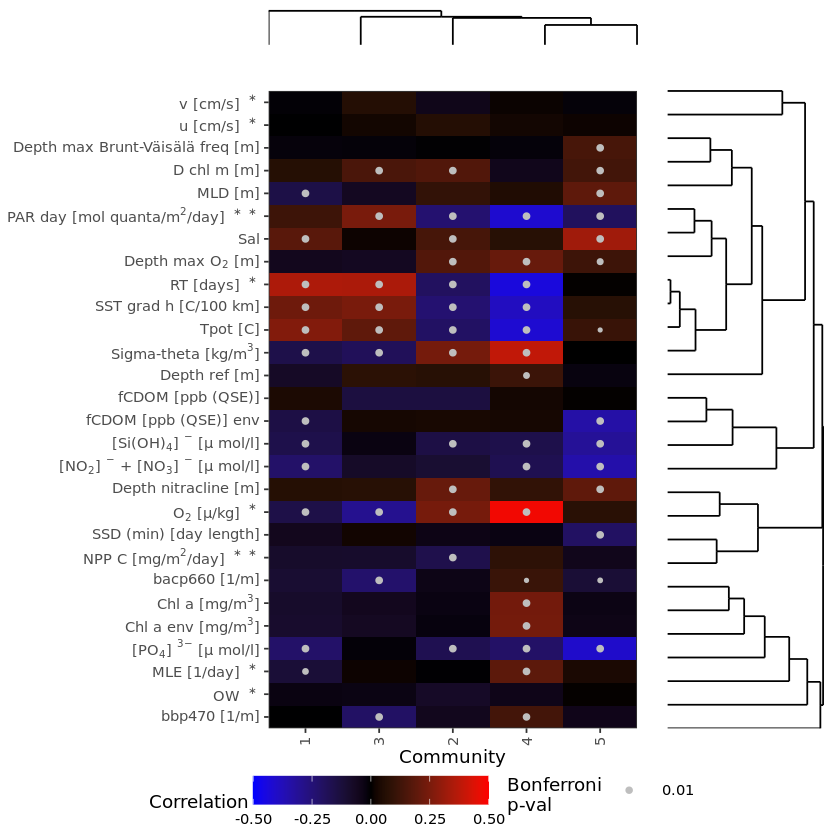

In [34]:
all_df_plot = all_df %>% dplyr::mutate(community = (as.character(community))) %>%
                        dplyr::mutate(Community = case_when(!is.na(community) ~ community,
                                            TRUE ~ "NoCommunity")) %>%
                        dplyr::filter(Community != "NoCommunity")

cluster_dendro = as.dendrogram(hclust(dist(t(corr_df),method="canberra")))
env_dendro = as.dendrogram(hclust(dist(t(corr_df_env),method="canberra")))
env.order <- order.dendrogram(env_dendro)

all_df_plot$Cor_Var_Ordered <- factor(x = all_df_plot$Cor_Var,
                               levels = colnames(corr_df_env)[env.order], 
                               ordered = TRUE)
all_df_plot$Cor_Var_Ordered <- match(all_df_plot$Cor_Var_Ordered,colnames(corr_df_env)[env.order])
comm.order <- order.dendrogram(cluster_dendro)

all_df_plot$Comm_Ordered <- factor(x = all_df_plot$community,
                               levels = colnames(corr_df)[comm.order], 
                               ordered = TRUE)
all_df_plot$Comm_Ordered <- match(all_df_plot$Comm_Ordered,colnames(corr_df)[comm.order])

#all_df_plot$Comm_Ordered=factor(as.numeric(all_df_plot$community))

dendro_env_labels = dendro_data(env_dendro, type = "rectangle")$labels
dendro_comm_labels = dendro_data(cluster_dendro, type = "rectangle")$labels
pacman::p_load(latex2exp)
corr_comm_only = ggplot(all_df_plot) + 
    geom_tile(aes(x=Comm_Ordered,y=Cor_Var_Ordered,fill=Cor)) +
    geom_point(aes(x=Comm_Ordered,y=Cor_Var_Ordered,size=Cor_Pval),color="gray") +
    scale_fill_gradient2(limits=c(-0.5,0.5),high = "red", mid = "black", low = "blue",name="Correlation ") +
    scale_size(trans = 'reverse',limits=c(0.1,0),range=c(0.5,1.5),breaks=c(0.01),name = "Bonferroni \np-val") +
    theme_test() +
    scale_y_continuous(breaks = dendro_env_labels$x, 
        labels = parse(text=TeX(dendro_env_labels$label, output="character")),
        #parse(text=levels(dendro_env_labels$label)),
        expand = c(0, 0)) + 
    scale_x_continuous(breaks = dendro_comm_labels$x, 
        labels = dendro_comm_labels$label,
        expand = c(0, 0)) + 
    ylab("") + xlab("Community") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
          legend.position = "bottom")
dendro_gg_env = ggplot(segment(dendro_data(env_dendro, type = "rectangle"))) + 
  geom_segment(aes(x = x, y = y, xend = xend, yend = yend)) + 
  coord_flip() +
  #scale_y_reverse(expand = c(0.2, 0)) + 
  scale_x_reverse(expand = c(0.2, 0)) + xlim(c(1,30)) + 
  theme_dendro()

dendro_gg_env = ggplot(segment(dendro_data(env_dendro, type = "rectangle"))) + 
  geom_segment(aes(x = x, y = y, xend = xend, yend = yend)) + 
  coord_flip() +
  scale_x_reverse(expand = c(0.2, 0)) + xlim(c(1,30)) + 
  scale_x_continuous(breaks = dendro_env_labels$x, 
                       labels = dendro_env_labels$label,
                       expand = c(0, 0)) + theme_dendro()

dendro_gg_comm = ggplot(segment(dendro_data(cluster_dendro, type = "rectangle"))) + 
  geom_segment(aes(x = x, y = y, xend = xend, yend = yend)) + 
  #scale_y_reverse(expand = c(0.2, 0)) + 
  theme_dendro()

dendro_gg_comm_labels = dendro_data(cluster_dendro, type = "rectangle")$labels
dendro_gg_comm = ggplot(segment(dendro_data(cluster_dendro, type = "rectangle"))) + 
  geom_segment(aes(x = x, y = y, xend = xend, yend = yend)) +
  scale_x_continuous(breaks = dendro_gg_comm_labels$x, 
                       labels = dendro_gg_comm_labels$label,
                       expand = c(0, 0)) + theme_dendro()

corr_comm_only_dendro = cowplot::plot_grid(dendro_gg_comm,
                                           corr_comm_only + theme(plot.margin=grid::unit(c(-10,-5,-3,-3), "mm"),
                                                                  legend.position="none"), 
                                           rel_heights=c(0.12,1),rel_widths=c(0.3,1,0.3,1),
                                           ncol=1, align="hv",axis = "tblr")
#t, r, b, l  (trouble, top-right-bottom-left)
corr_comm_only_alldendro = cowplot::plot_grid(corr_comm_only_dendro + 
                                              theme(plot.margin=grid::unit(c(0,0,0,0), "mm")),
                                              cowplot::plot_grid(NA,dendro_gg_env,
                                                                 rel_heights=c(0.12,1),ncol=1), #+ 
                                              #theme(plot.margin=grid::unit(c(-8,0,-25,-10), "mm")), 
                   rel_widths=c(1,0.3),ncol=2,align = "v", axis = "tb")
corr_comm_only_alldendro = cowplot::plot_grid(corr_comm_only_alldendro,
                                              get_legend(corr_comm_only+
                                                         theme(legend.key.width=unit(1,"cm"))),
                                              ncol=1,rel_heights=c(1,0.1))
corr_comm_only_alldendro

In [99]:
all_df_plot %>% dplyr::filter(Community == "5")

community,Cor,Cor_Pval,Cor_Var,Community,Cor_Var_Ordered,Comm_Ordered
<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>
5,-0.0202796723,1.000000e+00,Depth ref \[m\],5,16,5
5,0.3244515726,7.297598e-22,Sal,5,22,5
5,0.1076100103,9.096846e-02,Tpot \[$^o$C\],5,18,5
5,-0.0003894395,1.000000e+00,Sigma-theta \[kg/$m^3$\],5,17,5
5,0.0740279129,1.000000e+00,O$_2$ \[$\mu$/kg\] $^{*}$,5,10,5
5,-0.4069070060,7.358078e-36,\[PO$_4$\] $^{3-}$ \[$\mu$ mol/l\],5,4,5
5,-0.3478145198,2.141137e-25,\[NO$_2$\] $^{-}$ + \[NO$_3$\] $^{-}$ \[$\mu$ mol/l\],5,12,5
5,-0.3104253777,7.622507e-20,\[Si(OH)$_4$\] $^{-}$ \[$\mu$ mol/l\],5,13,5
5,-0.0349146505,1.000000e+00,Chl a env \[mg/m$^3$\],5,5,5


In [37]:
renamed_mags = read.csv("/vortexfs1/omics/alexander/halexander/2021-tara-final-paper/rename/renamed-eukaryotic-mags.tsv",sep="\t")

layout_gr_broadclasses = layout_gr_classes %>%
    #dplyr::left_join(cluster_groups, by = c("mag"="Cluster")) %>%
    dplyr::mutate(MAG=mag) %>%
    #dplyr::mutate(MAG = case_when((MAG != "") & !(is.na(MAG)) ~ MAG,
    #                              TRUE ~ mag)) %>%
    #dplyr::left_join(renamed_mags,by = c("MAG" = "old_mag_name")) %>%
    dplyr::mutate(new_mag_name=MAG) %>%
    dplyr::mutate(groups_full = paste(Domain,Clade,Kingdom,Supergroup,Phylum,Class,sep=";")) %>%
    dplyr::mutate(groups = case_when(Kingdom == "Fungi" ~ "Fungi",
                                     grepl("Metazoa",groups_full) ~ "Metazoa",
                                     grepl("Chlorophyta",groups_full) ~ "Chlorophyta",
                                     grepl("Cryptophyta",groups_full) ~ "Cryptophyta",
                                     grepl("Cryptophyceae",groups_full) ~ "Cryptophyta",
                                     grepl("Haptophyta",groups_full) ~ "Haptophyta",
                                     grepl("Ochrophyta",groups_full) ~ "Ochrophyta",
                                     (groups_full == "Alveolata;Ciliophora") ~ "Sar",
                                     (groups_full == "Alveolata;Dinoflagellata") ~ "Sar",
                                     (groups_full == "Stramenopiles;-") ~ "Sar",
                                     (groups_full == "Stramenopiles;") ~ "Sar",
                                      grepl("Amoebozoa",groups_full)  ~ "Amoebozoa",
                                      grepl("Apusozoa",groups_full)  ~ "Apusozoa",
                                     ((Kingdom == ".") & (Clade == "Sar") & 
                                     (Phylum == ".") & (Class == ".")) ~ "Sar",
                                     (groups_full == "-;") ~ "Eukaryota",
                                     (groups_full == "-;-") ~ "Eukaryota",
                                     (groups_full == ";-") ~ "Eukaryota",
                                     (Clade == "Sar") ~ "Sar",
                                     TRUE ~ "Bacteria"))%>%
                      dplyr::mutate(groups = as.character(groups)) %>%
                      dplyr::left_join(harriet_groups%>%dplyr::rename(c("HA_grp"="harriet_groups")),
                                                                      by = c("new_mag_name"="X")) %>%
                      dplyr::mutate(harriet_groups = as.character(HA_grp)) %>%
                      dplyr::mutate(groups = case_when((HA_grp != "") & !is.na(HA_grp) ~ HA_grp,
                                                       TRUE ~ groups))

color_groups = read.csv('/vortexfs1/omics/alexander/halexander/2021-tara-final-paper/data/taxonomy_color_ranges.csv', 
                   row.names=1) %>% dplyr::mutate(mags = rownames(.)) %>%
                    #dplyr::left_join(renamed_mags,
                    # by = c("mags" = "old_mag_name")) %>%
                   dplyr::mutate(new_mag_name=mags) %>%
                   dplyr::rename("groups_full" = "name") %>%
                   dplyr::mutate(groups = case_when(grepl("Fungi",groups_full) ~ "Fungi",
                                     grepl("Metazoa",groups_full) ~ "Metazoa",
                                     grepl("Chlorophyta",groups_full) ~ "Chlorophyta",
                                     grepl("Cryptophyta",groups_full) ~ "Cryptophyta",
                                     grepl("Cryptophyceae",groups_full) ~ "Cryptophyta",
                                     grepl("Haptophyta",groups_full) ~ "Haptophyta",
                                     grepl("Ochrophyta",groups_full) ~ "Ochrophyta",
                                     (groups_full == "Alveolata;Ciliophora") ~ "Sar",
                                     (groups_full == "Alveolata;Dinoflagellata") ~ "Sar",
                                     (groups_full == "Stramenopiles;-") ~ "Sar",
                                     (groups_full == "Stramenopiles;") ~ "Sar",
                                      grepl("Amoebozoa",groups_full)  ~ "Amoebozoa",
                                      grepl("Apusozoa",groups_full)  ~ "Apusozoa",
                                     (grepl("SAR",groups_full) | 
                                      grepl("Stramenopiles",groups_full) | 
                                      grepl("Alveolata",groups_full)) ~ "Sar",
                                     (groups_full == "-;") ~ "Eukaryota",
                                     (groups_full == "-;-") ~ "Eukaryota",
                                     (groups_full == ";-") ~ "Eukaryota",
                                     grepl("Eukaryota",groups_full) ~ "Eukaryota",
                                     TRUE ~ "Bacteria"))%>%
                      dplyr::mutate(groups = as.character(groups)) %>%
                      dplyr::left_join(harriet_groups%>%dplyr::rename(c("HA_grp"="harriet_groups")),
                                                                      by = c("new_mag_name"="X")) %>%
                      dplyr::mutate(harriet_groups = as.character(HA_grp)) %>%
                      dplyr::mutate(groups = case_when((HA_grp != "") & !is.na(HA_grp) ~ HA_grp,
                                                       TRUE ~ groups))

distinct_cols <- c("#4b9200","#98008d","#93d779","black","#ff55b0","#2a5e2b",
                   "#e195ff","#fb9113","#01acc8","#f12450","#7d6100",
                   "#793e69","#a54d00","#f2bb95")
community_cols = data.frame("community" = c(1:7), "commcolors" = distinct_cols[8:14])
layout_gr_broadclasses = layout_gr_broadclasses %>% 
    dplyr::left_join(color_groups %>% dplyr::mutate(groups=case_when(groups=="Sar" ~ "SAR",
                                                              TRUE ~ groups)) %>%
                     dplyr::select(color,groups), by = "groups") %>%
    dplyr::mutate(color = as.character(color)) %>%
    dplyr::mutate(community = as.numeric(community)) %>%
    dplyr::left_join(community_cols) %>%
    dplyr::mutate(commcolors = as.character(commcolors)) %>%
    dplyr::mutate(color = case_when((groups == "Bacteria") ~ "white",#commcolors,#"white",
                                    #(groups == "Amoebozoa") ~ "yellow",
                                    #(groups == "Apusozoa") ~ "#daa520",
                                    (groups == "Amoebozoa") ~ '#E66B92',
                                    (groups == "Choanozoa") ~ '#FCDCFF',
                                    (groups == "Dinoflagellata") ~ '#18AB7B',
                                    (groups == "Apusozoa") ~ '#9A6ACD',
                                    (groups == "Cryptophyta") ~ '#C6BE53',
                                    TRUE ~ color)) %>%
    dplyr::distinct()

Joining, by = "community"


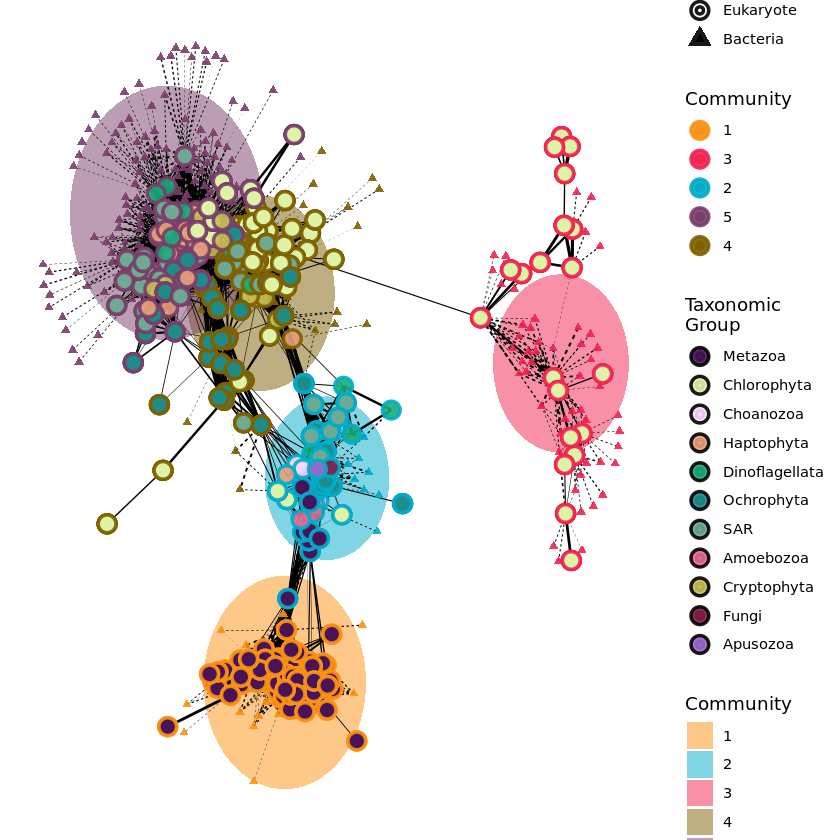

In [40]:
cluster_centers = layout_gr %>% dplyr::group_by(community) %>% 
                    dplyr::filter(!is.na(community)) %>%
                    dplyr::filter(community < 10) %>%
                    dplyr::summarize(mean_x = mean(V1),mean_y=mean(V2),n_points=n())
distinct_cols <- c("#6068da","#50c150","#8f45b4","#acb833","#c273e5",
                   "#81b84c","#c84aa9","#428529","#e64586","#5cc799",
                   "#b53b6d","#5eae6c","#cc454d","#41bcb8","#d2522c",
                   "#48a8d7","#da9c31","#4a68b5","#96872b","#a792df",
                   "#686d2b","#88589b","#b1b268","#6e94d7","#9d5e2e",
                   "#d987c3","#377c53","#e18088","#dd9662","#9b4d68")
distinct_cols <- c("#4b9200","#98008d","#93d779","black","#ff55b0","#2a5e2b",
                   "#e195ff","#fb9113","#01acc8","#f12450","#7d6100",
                   "#793e69","#a54d00","#f2bb95","black","white")
network_plot = ggplot() +
    ggforce::geom_circle(data = cluster_centers, aes(x0 = mean_x, y0 = mean_y, r = (n_points)^(1/3),
                                                     fill = factor(community)), col = NA, alpha = 0.5) + 
    scale_fill_manual(name = "Community", breaks = (layout_gr_broadclasses %>% dplyr::arrange(community))$community, 
                      values = (layout_gr_broadclasses %>% dplyr::arrange(community))$commcolors) + #values = distinct_cols) + #[8:14]) + 
    geom_segment(data=edge_df,aes(x=from.x,xend = to.x,y=from.y,
                                  yend = to.y,size=corrcoef,lty=Link),colour="black") +
    new_scale_fill() + 
    geom_point(data=layout_gr_broadclasses %>% dplyr::filter(Kingdom != "Eukaryota"), #%>% 
               #dplyr::mutate(groups = case_when((is.na(Supergroup)) | (Supergroup == "NA") ~ "Bacteria",
               #                                     TRUE ~ Supergroup)),
               aes(x=V1,y=V2,shape=factor(eukprok),fill=factor(groups),color=factor(community)),
               alpha=0.9,stroke=1.5,size=1) +
    geom_point(data=layout_gr_broadclasses %>% dplyr::filter(Kingdom == "Eukaryota"),
               aes(x=V1,y=V2,shape=factor(eukprok),fill=factor(groups),color=factor(community)),
               alpha=0.9,stroke=1.5,size=4) +
    scale_fill_manual(name = "Taxonomic\nGroup", 
                      breaks = (layout_gr_broadclasses %>% dplyr::filter(groups!="Bacteria"))$groups, 
                      values = (layout_gr_broadclasses %>% dplyr::filter(groups!="Bacteria"))$color) + #values = distinct_cols[1:7]) + 
    scale_color_manual(name = "Community", 
                      breaks = (layout_gr_broadclasses)$community, 
                      values = (layout_gr_broadclasses)$commcolors) + #values = distinct_cols) + #[8:14]) + 
    guides(fill = guide_legend(override.aes = list("shape"=21))) + 
    theme_bw() +
    scale_shape_manual(name = "", values=c(21,17), breaks = c("euk","prok"), labels = c("Eukaryote","Bacteria")) + 
    scale_size(range = c(0, 1),labels=c("0.7","0.8","0.9"),breaks=c(0.7,0.8,0.9),name="") + 
    theme(
      axis.text.x = element_blank(),  # remove x-axis text
      axis.text.y = element_blank(), # remove y-axis text
      axis.ticks = element_blank(),  # remove axis ticks
      axis.title.x = element_blank(), # remove x-axis labels
      axis.title.y = element_blank(), # remove y-axis labels
      panel.background = element_blank(), 
      panel.border =element_blank(), 
      panel.grid.major = element_blank(),  #remove major-grid labels
      panel.grid.minor = element_blank(),  #remove minor-grid labels
      plot.background = element_blank())
network_plot
ggsave(file.path("..","figures","network_plot.png"),width=10,height=12,units="in")

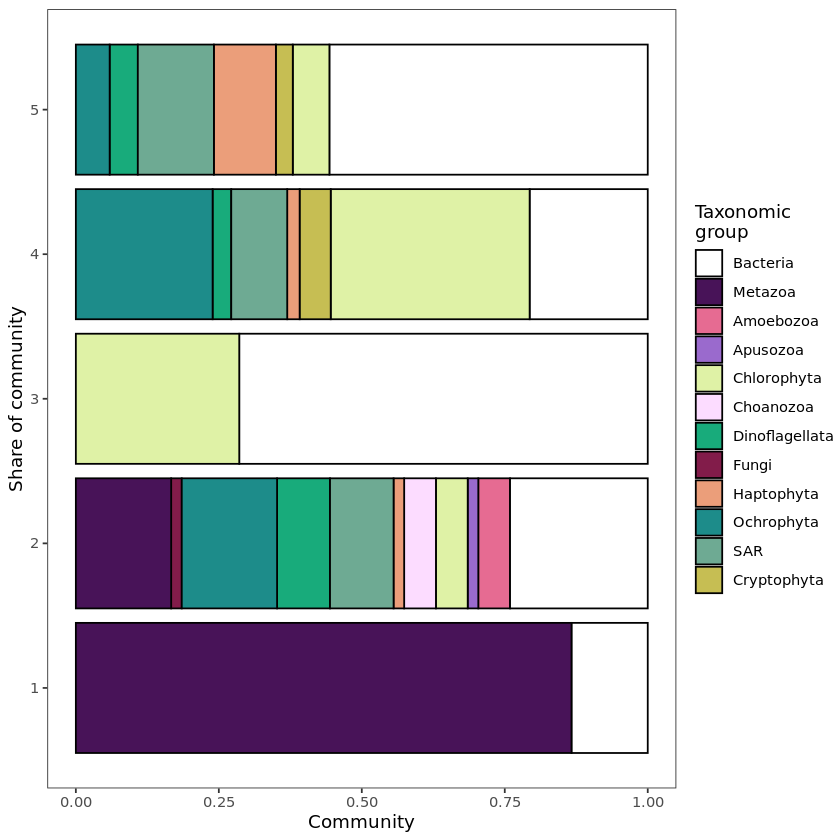

In [44]:
distinct_cols = total_communities_supergroup %>% dplyr::ungroup() %>% dplyr::distinct(groups,color)

total_communities_supergroup = layout_gr_broadclasses %>% dplyr::distinct(mag,.keep_all=TRUE) %>% 
    dplyr::group_by(community,groups,color) %>% 
    dplyr::mutate(groups = case_when(groups == "NA" ~ "Bacteria",
                                         TRUE ~ groups)) %>% dplyr::tally()

total_communities_supergroup$groups = ordered(total_communities_supergroup$groups,
                                       levels=c("Bacteria","Amoebozoa","Apusozoa","Chlorophyta","Choanozoa",
                                                       "Cryptophyta","Haptophyta","SAR","Dinoflagellata",
                                                       "Ochrophyta","Fungi","Metazoa"))
total_comm_bar = ggplot(total_communities_supergroup) + geom_bar(aes(x = community, y = n, 
                                                                     fill = groups),
                                            position = "fill", stat = "identity",color="black") + coord_flip() + 
    theme_test() + ylab("Community") + xlab("Share of community") + 
    scale_fill_manual(name = "Taxonomic\ngroup", breaks = distinct_cols$groups,
                      values = distinct_cols$color)
total_comm_bar

In [47]:
reclustered_network_posneg = for_igraph_buscofilt_all %>% 
    dplyr::mutate("Classifications_from" = get_tax_string_no_cluster(for_igraph_buscofilt_all$from)) %>%
    dplyr::mutate("Classifications_to" = get_tax_string_no_cluster(for_igraph_buscofilt_all$to)) %>%
    separate(Classifications_to, sep = ";", fill = "left",
                    paste0(c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_to")) %>%
    separate(Classifications_from, sep = ";", fill = "left",
                    paste0(c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_from")) %>%
    dplyr::mutate(Cluster_From=from,Cluster_To=to) %>%
    #dplyr::left_join(cluster_groups, by=c("from"="MAG")) %>%
    #dplyr::rename(c("Cluster_From" = "from")) %>%
    #dplyr::left_join(cluster_groups, by=c("to"="MAG")) %>%
    #dplyr::rename(c("Cluster_To" = "to")) %>%  
    dplyr::mutate(from = case_when(grepl("Cluster", Cluster_From) ~ Cluster_From,
                                   TRUE ~ from)) %>%
    dplyr::mutate(to = case_when(grepl("Cluster", Cluster_To) ~ Cluster_To,
                                   TRUE ~ to)) %>%
    dplyr::filter(abs(corrcoef) > 0.7) %>%
    dplyr::filter(from != to) 
reclustered_network_posneg$Domain_to[is.na(reclustered_network_posneg$Domain_to)] = "Bacteria"
reclustered_network_posneg$Domain_from[is.na(reclustered_network_posneg$Domain_from)] = "Bacteria"

tracking_communities = reclustered_network_posneg %>% dplyr::left_join(layout_gr_broadclasses %>% #dplyr::select(mag,community,classification) %>%
                             dplyr::rename(c("community_to" = "community",
                                             "Domain_to" = "Domain",
                                             "Supergroup_to" = "Supergroup",
                                             "Group_to" = "groups",
                                             "Phylum_to" = "Phylum",
                                             "degree_to" = "degree")), by = c("to" = "mag")) %>%
            dplyr::left_join(layout_gr_broadclasses %>% #dplyr::select(mag,community,classification) %>%
                             dplyr::rename(c("community_from" = "community",
                                             "Domain_from" = "Domain",
                                             "Supergroup_from" = "Supergroup",
                                             "Group_from" = "groups",
                                             "Phylum_from" = "Phylum",
                                             "degree_from" = "degree")), by = c("from" = "mag")) %>%
            dplyr::distinct(.keep_all=TRUE)

#We want to divide the number of connections actually observed between each community to 
# the total possible between two communities, which is the size of the two communities
# multiplied together.
get_combo <- function(df_graph) { 
    combined_clust = c()
    for (i in c(1:length(df_graph$from))) {
        combined_clust = c(combined_clust,paste(sort(c(df_graph$from[i],df_graph$to[i])),collapse="_"))
    }
    return(combined_clust)
}
tracking_communities = tracking_communities %>% 
    dplyr::arrange(desc(corrcoef)) %>%
    dplyr::distinct(to,from,.keep_all=TRUE) %>%
    dplyr::filter(Link != "Other")
tracking_communities$comboclust = get_combo(tracking_communities)
tracking_communities = tracking_communities %>% 
    dplyr::arrange(desc(corrcoef)) %>%
    dplyr::distinct(comboclust,.keep_all=TRUE)
summarized_connections = tracking_communities %>% 
    dplyr::filter(!is.na(community_to) & !is.na(community_from)) %>%
    dplyr::group_by(community_to,community_from) %>% 
    dplyr::summarize(corrcoefmean = mean(corrcoef),number_connections=n()) %>%
    dplyr::left_join(total_communities %>% dplyr::rename("size_to"="n"),by = c("community_to"="community")) %>%
    dplyr::left_join(total_communities %>% dplyr::rename("size_from"="n"),by = c("community_from"="community")) %>%
    dplyr::mutate(possible_between = size_to * size_from)

total_communities = layout_gr_classes %>% 
    dplyr::group_by(community) %>% dplyr::tally() %>%
    dplyr::mutate(community = as.integer(community))

df1 = tracking_communities %>% 
    dplyr::filter(!is.na(community_to) & !is.na(community_from)) %>%
    dplyr::distinct(from,community_to,.keep_all=T) %>%
    dplyr::rename("candidate"="from")

df2 = tracking_communities %>% 
    dplyr::filter(!is.na(community_to) & !is.na(community_from)) %>%
    dplyr::distinct(to,community_from,.keep_all=T) %>%
    dplyr::rename("candidate"="to")
tester = df1 %>% dplyr::bind_rows(df2) %>% 
    dplyr::distinct(candidate,community_to,community_from,.keep_all=T) %>% 
    dplyr::group_by(community_to,community_from) %>% 
    dplyr::tally() %>%
    dplyr::rename("number_connections" = "n")

summarized_connections = tracking_communities %>% 
    dplyr::filter(!is.na(community_to) & !is.na(community_from)) %>%
    dplyr::group_by(community_to,community_from) %>% 
    dplyr::summarize(corrcoefmean = mean(corrcoef),dense_connections=n()) %>%
    dplyr::left_join(tester,by=c("community_to","community_from")) %>%
    dplyr::mutate(number_connections = case_when(community_to==community_from ~ dense_connections,
                                                 TRUE ~ number_connections)) %>%
    dplyr::left_join(total_communities %>% dplyr::rename("size_to"="n"),by = c("community_to"="community")) %>%
    dplyr::left_join(total_communities %>% dplyr::rename("size_from"="n"),by = c("community_from"="community")) %>%
    dplyr::mutate(possible_between = max(size_to,size_from)) %>%# * size_from) %>%
    dplyr::mutate(possible_between = case_when(community_to==community_from ~ 
                                               as.integer((as.integer(size_to) * (as.integer(size_to) - 1)) / 2),
                                               #as.integer(lapply(lapply(size_to,as.integer),choose,2)),
                                               TRUE ~ possible_between))

`summarise()` has grouped output by 'community_to'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'community_to'. You can
override using the `.groups` argument.


In [62]:
summarized_connections %>% dplyr::mutate(connectedness=number_connections/possible_between) #%>%
    #dplyr::group_by(community_to) %>% 
    #dplyr::ungroup() %>%
    #dplyr::filter((community_to!=3)&(community_from!=3)) %>%
    #dplyr::summarize(mconnectedness=mean(connectedness))

community_to,community_from,corrcoefmean,dense_connections,number_connections,size_to,size_from,possible_between,connectedness
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,1,0.7789877,2691,2691,120,120,7140,0.376890756
1,2,0.7388961,13,14,120,54,120,0.116666667
1,3,0.7150497,1,2,120,70,120,0.016666667
2,1,0.7344827,32,28,54,120,120,0.233333333
2,2,0.7600432,387,387,54,54,1431,0.270440252
2,4,0.7270478,26,24,54,92,120,0.200000000
3,1,0.7312300,1,2,70,120,203,0.009852217
3,3,0.7772960,545,545,70,70,2415,0.225672878
3,4,0.8482537,4,4,70,92,203,0.019704433


In [48]:
degree_strength = ggplot(summarized_connections) + 
    geom_tile(aes(x = factor(community_to), y = factor(community_from), 
                  fill = number_connections/possible_between)) + 
    geom_point(aes(x = factor(community_to), y = factor(community_from), 
                  size = corrcoefmean)) + 
    theme_test() + 
    ylab("Community 2") + xlab("Community 1") + 
    scale_fill_gradientn(colors=c("white","gold","orange","red"),limits=c(0,1),name="Connectedness") + 
    scale_size(name = "Mean \ncorrelation\ncoefficient",breaks=c(0.7,0.75,0.8))

In [49]:
degree_strength_legend = get_legend(degree_strength +
    theme(legend.position="bottom"))
total_all = total_communities_supergroup %>% dplyr::group_by(community) %>% dplyr::summarize(n_tot = sum(n))
total_comm_bar = total_comm_bar + geom_text(data = total_all, 
                                            aes(y=0.85,label=paste0("n=",n_tot),x=community),size=6)
grid_degree = cowplot::plot_grid(degree_strength + theme(legend.position = "none"),
                   total_comm_bar + theme(axis.text.y = element_blank(),
                                    axis.ticks.y = element_blank(),
                                    axis.title.y = element_blank() )+ 
                   ylab("Share of total community"), align = "bt", rel_widths=c(0.75,1))
degree_strength = cowplot::plot_grid(grid_degree,degree_strength_legend,ncol=1,rel_heights=c(1,0.25))

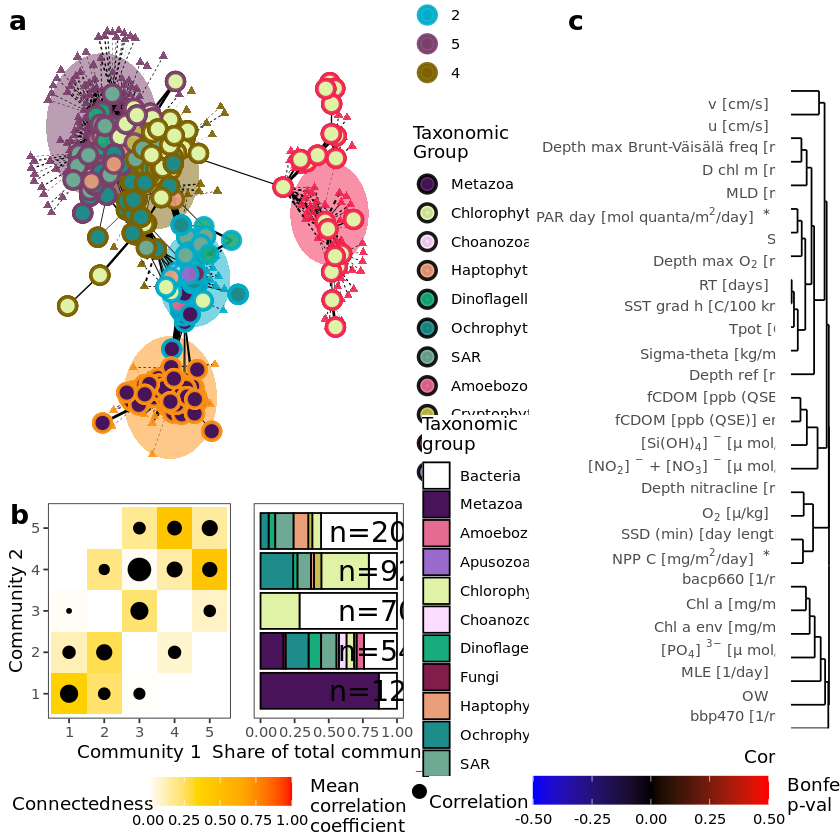

In [50]:
grid1 = cowplot::plot_grid(network_plot,degree_strength,nrow=2,rel_heights=c(1,0.7),labels=c("a","b"),label_size=16)
grid2 = cowplot::plot_grid(grid1,corr_comm_only_alldendro,nrow=1,rel_widths=c(1,0.5),labels=c("","c"),label_size=16) #,rel_heights=c(1,0.5))
grid2 
ggsave(file.path("..","figures","fig6_alexander_2022.png"),width=13,height=13,units="in",dpi=400)
ggsave(file.path("..","figures","fig6_alexander_2022.pdf"),width=14,height=13,units="in",dpi=400,useDingbats=FALSE)

In [19]:
layout_gr_classes %>%
    dplyr::left_join(translation_dict,by=c("mag"="new_mag_name")) %>%
    dplyr::left_join(prokaryotic_taxonomy,by=c("mag"="new_mag_name"))

V1,V2,eukprok,mag,Domain,Clade,Kingdom,Supergroup,Phylum,Class,⋯,Genus,Species,community,degree,old_mag_name,Genome,Phylum_Bact,Class_Bact,Order_Bact,Family_Bact
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
-11.470440,-10.361808,euk,TOPAZ_SPS4_E052,NA,Metazoa,Eukaryota,Metazoa,Arthropoda,-,⋯,-,-,1,68,SPO-all-SRF-180-2000-00_bin-318,NA,NA,NA,NA,NA
-11.508402,-10.780870,euk,TOPAZ_SPS3_E064,NA,Metazoa,Eukaryota,Metazoa,Arthropoda,-,⋯,-,-,1,70,SPO-all-SRF-20-180-00_bin-146,NA,NA,NA,NA,NA
18.776347,-4.903280,euk,TOPAZ_NPS1_E017,NA,Chlorophyta,Eukaryota,Archaeplastida,Chlorophyta,-,⋯,-,-,3,3,NPO-all-SRF-0-8-5-00_bin-371,NA,NA,NA,NA,NA
-13.578087,-8.444532,euk,TOPAZ_SPS3_E018,NA,Metazoa,Eukaryota,Metazoa,Arthropoda,-,⋯,-,-,1,41,SPO-SPSG-SRF-20-180-00_bin-113,NA,NA,NA,NA,NA
-4.788521,-2.478380,euk,TOPAZ_SPS1_E084,NA,Choanozoa,Eukaryota,-,-,-,⋯,-,-,2,20,SPO-all-SRF-0-8-5-00_bin-849,NA,NA,NA,NA,NA
-13.163712,-9.527514,euk,TOPAZ_SAS3_E005,NA,Metazoa,Eukaryota,Metazoa,Arthropoda,-,⋯,-,-,1,63,SAO-all-SRF-20-180-00_bin-36,NA,NA,NA,NA,NA
-12.558574,-9.719613,euk,TOPAZ_SPS3_E081,NA,Metazoa,Eukaryota,Metazoa,Arthropoda,-,⋯,-,-,1,79,SPO-all-SRF-20-180-00_bin-23,NA,NA,NA,NA,NA
-13.053551,-10.170808,euk,TOPAZ_SAS3_E014,NA,Metazoa,Eukaryota,Metazoa,Arthropoda,-,⋯,-,-,1,42,SAO-all-SRF-20-180-00_bin-78,NA,NA,NA,NA,NA
-13.592137,-8.136002,euk,TOPAZ_SPS3_E077,NA,Metazoa,Eukaryota,Metazoa,Arthropoda,-,⋯,-,-,1,37,SPO-all-SRF-20-180-00_bin-202,NA,NA,NA,NA,NA


In [22]:
layout_gr_classes %>%
    dplyr::left_join(translation_dict,by=c("mag"="new_mag_name")) %>%
    dplyr::left_join(prokaryotic_taxonomy,by=c("mag"="new_mag_name")) %>%
    dplyr::select(V1,V2,eukprok,mag,old_mag_name,degree,community,Domain,ends_with("Bact"))

V1,V2,eukprok,mag,old_mag_name,degree,community,Domain,Phylum_Bact,Class_Bact,Order_Bact,Family_Bact
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
-11.470440,-10.361808,euk,TOPAZ_SPS4_E052,SPO-all-SRF-180-2000-00_bin-318,68,1,NA,NA,NA,NA,NA
-11.508402,-10.780870,euk,TOPAZ_SPS3_E064,SPO-all-SRF-20-180-00_bin-146,70,1,NA,NA,NA,NA,NA
18.776347,-4.903280,euk,TOPAZ_NPS1_E017,NPO-all-SRF-0-8-5-00_bin-371,3,3,NA,NA,NA,NA,NA
-13.578087,-8.444532,euk,TOPAZ_SPS3_E018,SPO-SPSG-SRF-20-180-00_bin-113,41,1,NA,NA,NA,NA,NA
-4.788521,-2.478380,euk,TOPAZ_SPS1_E084,SPO-all-SRF-0-8-5-00_bin-849,20,2,NA,NA,NA,NA,NA
-13.163712,-9.527514,euk,TOPAZ_SAS3_E005,SAO-all-SRF-20-180-00_bin-36,63,1,NA,NA,NA,NA,NA
-12.558574,-9.719613,euk,TOPAZ_SPS3_E081,SPO-all-SRF-20-180-00_bin-23,79,1,NA,NA,NA,NA,NA
-13.053551,-10.170808,euk,TOPAZ_SAS3_E014,SAO-all-SRF-20-180-00_bin-78,42,1,NA,NA,NA,NA,NA
-13.592137,-8.136002,euk,TOPAZ_SPS3_E077,SPO-all-SRF-20-180-00_bin-202,37,1,NA,NA,NA,NA,NA


In [ ]:
dir.create(file.path("/vortexfs1","omics",
                      "alexander","share",
                      "2022-03-25_mags_communities/2022-10-17"))
write.csv(layout_gr_classes %>% dplyr::select(-c(V1,V2)),file.path("/vortexfs1","omics",
                                                                      "alexander","share",
                                                                      "2022-03-25_mags_communities/2022-10-17",
                                                                      "all_mags_communities.csv"))

write.csv(layout_gr_classes %>%
    dplyr::left_join(translation_dict,by=c("mag"="new_mag_name")) %>%
    dplyr::left_join(prokaryotic_taxonomy,by=c("mag"="new_mag_name")) %>%
    dplyr::select(V1,V2,eukprok,mag,old_mag_name,degree,community,ends_with("Bact")) %>% 
    dplyr::filter((grepl("_P",mag))) %>% dplyr::mutate(Domain="Bacteria"),
    file.path("/vortexfs1","omics",
              "alexander","share",
              "2022-03-25_mags_communities/2022-10-17",
              "prok_mags_communities.csv"))